# Capstone: Twitter Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from PIL import Image
from wordcloud import WordCloud
from pylab import *
from time import time
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer


plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ModuleNotFoundError: No module named 'wordcloud'

In [15]:
#load the csv file ("Sentiment140", which originated from Stanford University)
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("data/traindata.csv", header=None, names=cols)
testdata = pd.read_csv("data/testdata.csv", header=None, names=cols)
df.head()

sentiment          id                          date query_string  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009     NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009     NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009     NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [16]:
testdata.head()

sentiment  id                          date query_string      user  \
0          4   3  Mon May 11 03:17:40 UTC 2009      kindle2    tpryan   
1          4   4  Mon May 11 03:18:03 UTC 2009      kindle2    vcu451   
2          4   5  Mon May 11 03:18:54 UTC 2009      kindle2    chadfu   
3          4   6  Mon May 11 03:19:04 UTC 2009      kindle2     SIX15   
4          4   7  Mon May 11 03:21:41 UTC 2009      kindle2  yamarama   

                                                text  
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  
1  Reading my kindle2...  Love it... Lee childs i...  
2  Ok, first assesment of the #kindle2 ...it fuck...  
3  @kenburbary You'll love your Kindle2. I've had...  
4  @mikefish  Fair enough. But i have the Kindle2...

In [17]:
print len(df)
print len(testdata)

1600000
498


In [18]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [19]:
testdata.sentiment.value_counts()

4    182
0    177
2    139
Name: sentiment, dtype: int64

In [20]:
df.drop(['id', 'date', 'query_string', 'user'], axis=1, inplace=True)

In [24]:
df[df.sentiment == 0].head()

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

In [10]:
df['pre_clean_len'] = [len(t) for t in df.text]

In [11]:
#Create a data dictionary of the above data
from pprint import pprint
data_dict = {
    'sentiment': {
        'type': df.sentiment.dtype,
        'description': 'sentiment class - 0:Negative, 1:Positive'
    },
    'text': {
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len': {
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}

pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:Negative, 1:Positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


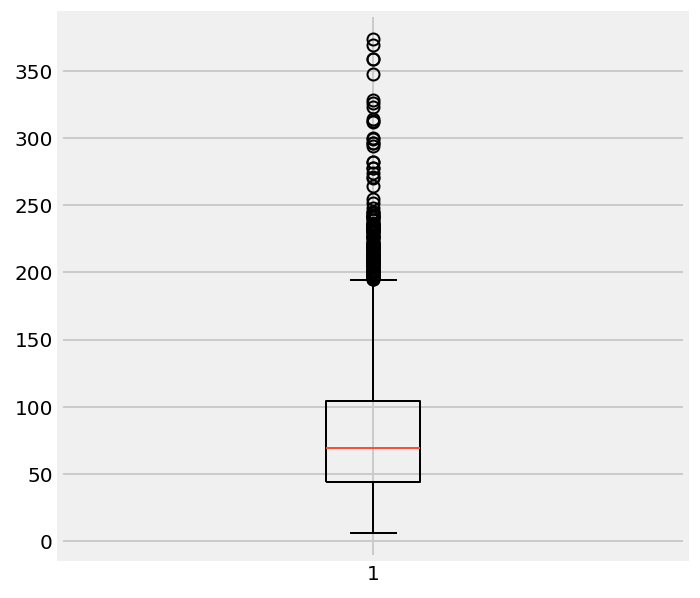

In [12]:
#plot pre_clean_len with box plot, so that I can see the overall distribution of length of strings in each entry
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [13]:
#This looks a bit strange, since the twitter’s character limit is 140. 
#But from the above box plot, some of the tweets are way more than 140 characters long

len(df[df.pre_clean_len > 140])

17174

In [14]:
df[df.pre_clean_len > 140].head(10)

sentiment                                               text  \
213           0  Awwh babs... you look so sad underneith that s...   
226           0  Tuesday�ll start with reflection �n then a lec...   
279           0  Whinging. My client&amp;boss don't understand ...   
343           0  @TheLeagueSF Not Fun &amp; Furious? The new ma...   
400           0  #3 woke up and was having an accident - &quot;...   
464           0  My bathtub drain is fired: it haz 1 job 2 do, ...   
492           0  pears &amp; Brie, bottle of Cabernet, and &quo...   
747           0  Have an invite for &quot;Healthy Dining&quot; ...   
957           0  Damnit I was really digging this season of Rea...   
1064          0  Why do I keep looking...I know that what I rea...   

      pre_clean_len  
213             142  
226             141  
279             145  
343             145  
400             144  
464             146  
492             150  
747             141  
957             141  
1064            141

# Data Preparation 1: HTML decoding

It looks like HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc. Decoding HTML to general text will be my first step of data preparation

In [15]:
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [16]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print example1.get_text()

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


# Data Preparation 2: ‘@’mention

The second part of the preparation is dealing with @mention.
Even though @mention carries a certain information (which another user that the tweet mentioned), this information doesn’t add value to build sentiment analysis model

In [17]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [18]:
#Replace @mention with the empty string
import re
re.sub(r'@[A-Za-z0-9]+', '', df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

# Data Preparation 3: URL links

The third part of the cleaning is dealing with URL links, same with @mention, even though it carries some information, for sentiment analysis purpose, this can be ignored.

In [19]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [20]:
re.sub('https?://[A-Za-z0-9./]+', '', df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

# Data Preparation 4: UTF-8 BOM (Byte Order Mark)

The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8.

By decoding text with ‘utf-8-sig’, this BOM will be replaced with unicode unrecognisable special characters, then I can process this as “?”

In [21]:
 df.text[226]

'Tuesday\xef\xbf\xbdll start with reflection \xef\xbf\xbdn then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [22]:
testing = df.text[226].decode('utf-8-sig')
testing

u'Tuesday\ufffdll start with reflection \ufffdn then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [23]:
testing.replace(u'\ufffd', '?')

u'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

# Data Preparation 5: hashtag / numbers

Sometimes the text used with hashtag can provide useful information about the tweet. It might be a bit risky to get rid of all the text together with the hashtag.
So I decided to leave the text intact and just remove the ‘#’. I will do this in the process of cleaning all the non letter characters including numbers

In [24]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [25]:
re.sub('[^a-zA-Z]', ' ', df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

# Defining data cleaning function

With above five data cleaning task, I will first define data cleaning function, and then will be applied to the whole dataset.

Tokenization, stemming/lemmatization, stop words will be dealt with later stage when creating matrix with either count vectorizer or Tfidf vectorizer.

In [26]:
from nltk.tokenize import WordPunctTokenizer

tok = WordPunctTokenizer()
mentions = r'@[A-Za-z0-9]+'
links = r'https?://[A-Za-z0-9./]+'
combined_pattern = r'|'.join((mentions, links))
www_pat = r'www.[^ ]+'
negations_dict = {"isn't": "is not", "aren't": "are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dict.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode('utf-8-sig').replace(u'\ufffd', '?')
    except:
        bom_removed = souped
    stripped = re.sub(combined_pattern, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dict[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", ' ', neg_handled)
    
    #Tokenize and join together to remove unneccessary white spaces created in the above lines
    words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    return (' '.join(words)).strip()       

In [27]:
testing = df.text[:100]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\encodings\utf_8_sig.py:19: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if input[:3] == codecs.BOM_UTF8:


[u'awww that bummer you shoulda got david carr of third day to do it',
 u'is upset that he can not update his facebook by texting it and might cry as result school today also blah',
 u'dived many times for the ball managed to save the rest go out of bounds',
 u'my whole body feels itchy and like its on fire',
 u'no it not behaving at all mad why am here because can not see you all over there',
 u'not the whole crew',
 u'need hug',
 u'hey long time no see yes rains bit only bit lol fine thanks how you',
 u'nope they did not have it',
 u'que me muera',
 u'spring break in plain city it snowing',
 u'just re pierced my ears',
 u'could not bear to watch it and thought the ua loss was embarrassing',
 u'it it counts idk why did either you never talk to me anymore',
 u'would ve been the first but did not have gun not really though zac snyder just doucheclown',
 u'wish got to watch it with you miss you and how was the premiere',
 u'hollis death scene will hurt me severely to watch on film wry is

In [28]:
nums = [0, 400000, 800000, 1200000, 1600000]
print "Cleaning and parsing the tweets...  \n"
clean_tweet_texts = []
for i in xrange(nums[0], nums[4]):
    if((i + 1) % 10000 == 0):
        print "Tweets %d of %d has been processed" %(i+1, nums[4])
    clean_tweet_texts.append(tweet_cleaner(df.text[i]))


Cleaning and parsing the tweets...  

Tweets 10000 of 1600000 has been processed
Tweets 20000 of 1600000 has been processed
Tweets 30000 of 1600000 has been processed
Tweets 40000 of 1600000 has been processed
Tweets 50000 of 1600000 has been processed
Tweets 60000 of 1600000 has been processed
Tweets 70000 of 1600000 has been processed
Tweets 80000 of 1600000 has been processed
Tweets 90000 of 1600000 has been processed
Tweets 100000 of 1600000 has been processed
Tweets 110000 of 1600000 has been processed
Tweets 120000 of 1600000 has been processed
Tweets 130000 of 1600000 has been processed
Tweets 140000 of 1600000 has been processed
Tweets 150000 of 1600000 has been processed
Tweets 160000 of 1600000 has been processed
Tweets 170000 of 1600000 has been processed
Tweets 180000 of 1600000 has been processed
Tweets 190000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 210000 of 1600000 has been processed
Tweets 220000 of 1600000 has been processed
Twe

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\bs4\__init__.py:219: UserWarning: " i just received my G8 viola exam.. and its... well... .. disappointing.. :\.." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Tweets 770000 of 1600000 has been processed
Tweets 780000 of 1600000 has been processed
Tweets 790000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 810000 of 1600000 has been processed
Tweets 820000 of 1600000 has been processed
Tweets 830000 of 1600000 has been processed
Tweets 840000 of 1600000 has been processed
Tweets 850000 of 1600000 has been processed
Tweets 860000 of 1600000 has been processed
Tweets 870000 of 1600000 has been processed
Tweets 880000 of 1600000 has been processed
Tweets 890000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 910000 of 1600000 has been processed
Tweets 920000 of 1600000 has been processed
Tweets 930000 of 1600000 has been processed
Tweets 940000 of 1600000 has been processed
Tweets 950000 of 1600000 has been processed
Tweets 960000 of 1600000 has been processed
Tweets 970000 of 1600000 has been processed
Tweets 980000 of 1600000 has been processed
Tweets 990000 of 1600000 has bee

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\bs4\__init__.py:219: UserWarning: "E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \../  \../" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Tweets 1300000 of 1600000 has been processed
Tweets 1310000 of 1600000 has been processed
Tweets 1320000 of 1600000 has been processed
Tweets 1330000 of 1600000 has been processed
Tweets 1340000 of 1600000 has been processed
Tweets 1350000 of 1600000 has been processed
Tweets 1360000 of 1600000 has been processed
Tweets 1370000 of 1600000 has been processed
Tweets 1380000 of 1600000 has been processed
Tweets 1390000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1410000 of 1600000 has been processed
Tweets 1420000 of 1600000 has been processed
Tweets 1430000 of 1600000 has been processed
Tweets 1440000 of 1600000 has been processed
Tweets 1450000 of 1600000 has been processed
Tweets 1460000 of 1600000 has been processed
Tweets 1470000 of 1600000 has been processed
Tweets 1480000 of 1600000 has been processed
Tweets 1490000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1510000 of 1600000 has been processed
Tweets 152

# Saving cleaned data as csv

In [29]:
clean_df = pd.DataFrame(clean_tweet_texts, columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()

text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [30]:
clean_df.to_csv('clean_tweet.csv', encoding='utf-8')

In [32]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv, index_col = 0)
my_df.head()

text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [33]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596499 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [34]:
my_df[my_df.isnull().any(axis=1)].head()

text  target
208   NaN       0
249   NaN       0
398   NaN       0
430   NaN       0
1011  NaN       0

In [35]:
np.sum(my_df.isnull().any(axis=1))

3501

In [36]:
(my_df.isnull().any(axis=0))

text       True
target    False
dtype: bool

It seems like 3,981 entries have null entries for text column. This is strange, because the original dataset had no null entries, thus if there are any null entries in the cleaned dataset, it must have happened during the cleaning process.


The only text information they had was either twitter ID or url address. Anyway, these are the info I decided to discard for the sentiment analysis, so I will drop these null rows, and update the data frame.

In [37]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True, inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596499 entries, 0 to 1596498
Data columns (total 2 columns):
text      1596499 non-null object
target    1596499 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Word Cloud

A word cloud represents word usage in a document by resizing individual words proportionally to its frequency, and then presenting them in random arrangement.

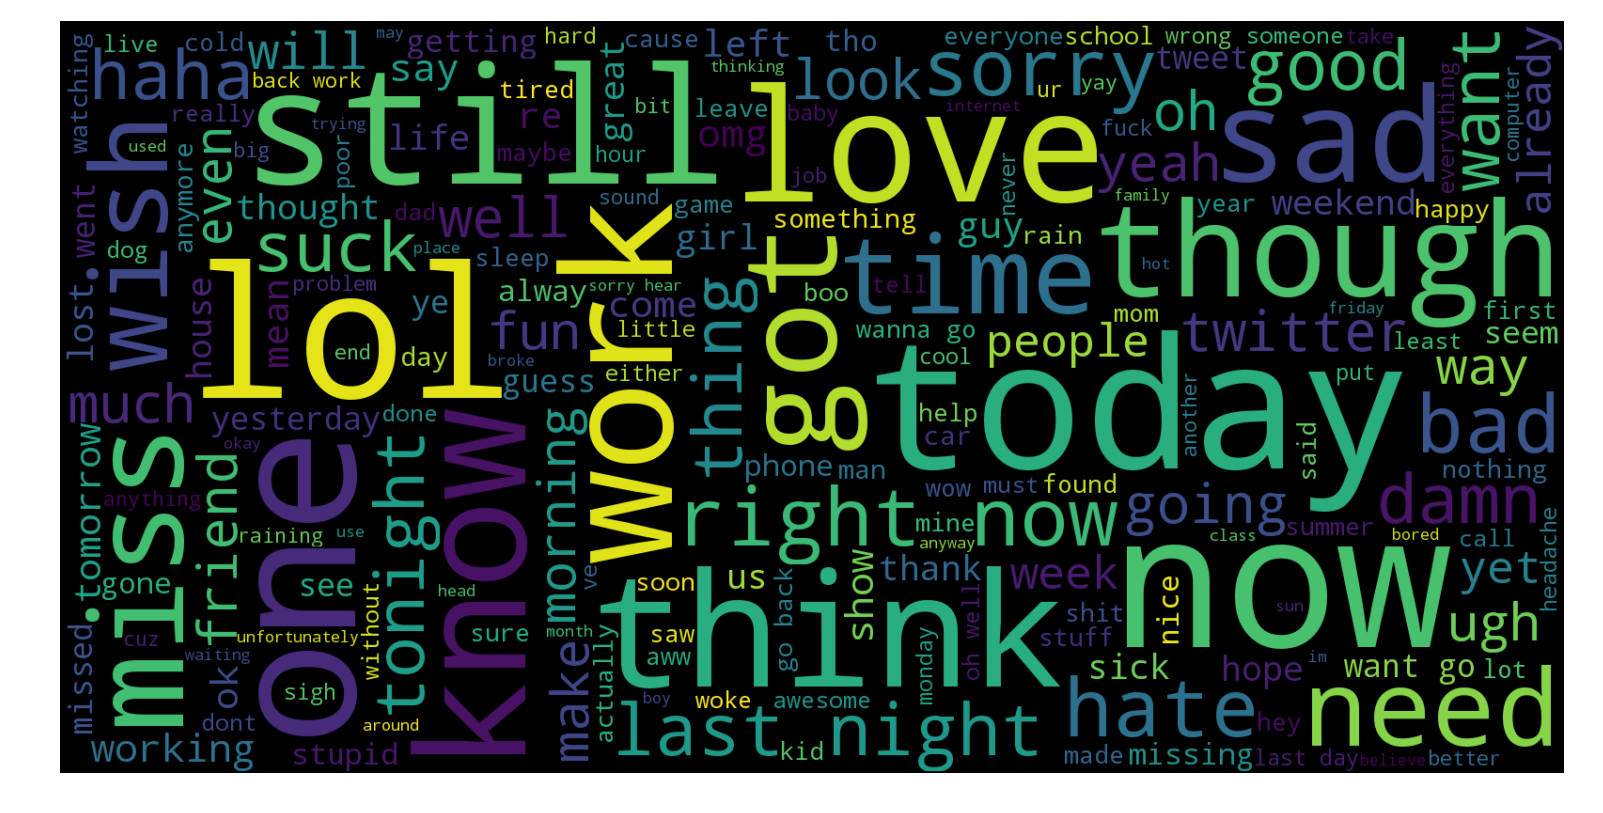

In [38]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [37]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print t

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


OK, even though the tweets contain the word “love”, in these cases it is negative sentiment, because the tweet has mixed emotions like “love” but “miss”. Or sometimes used in a sarcastic way

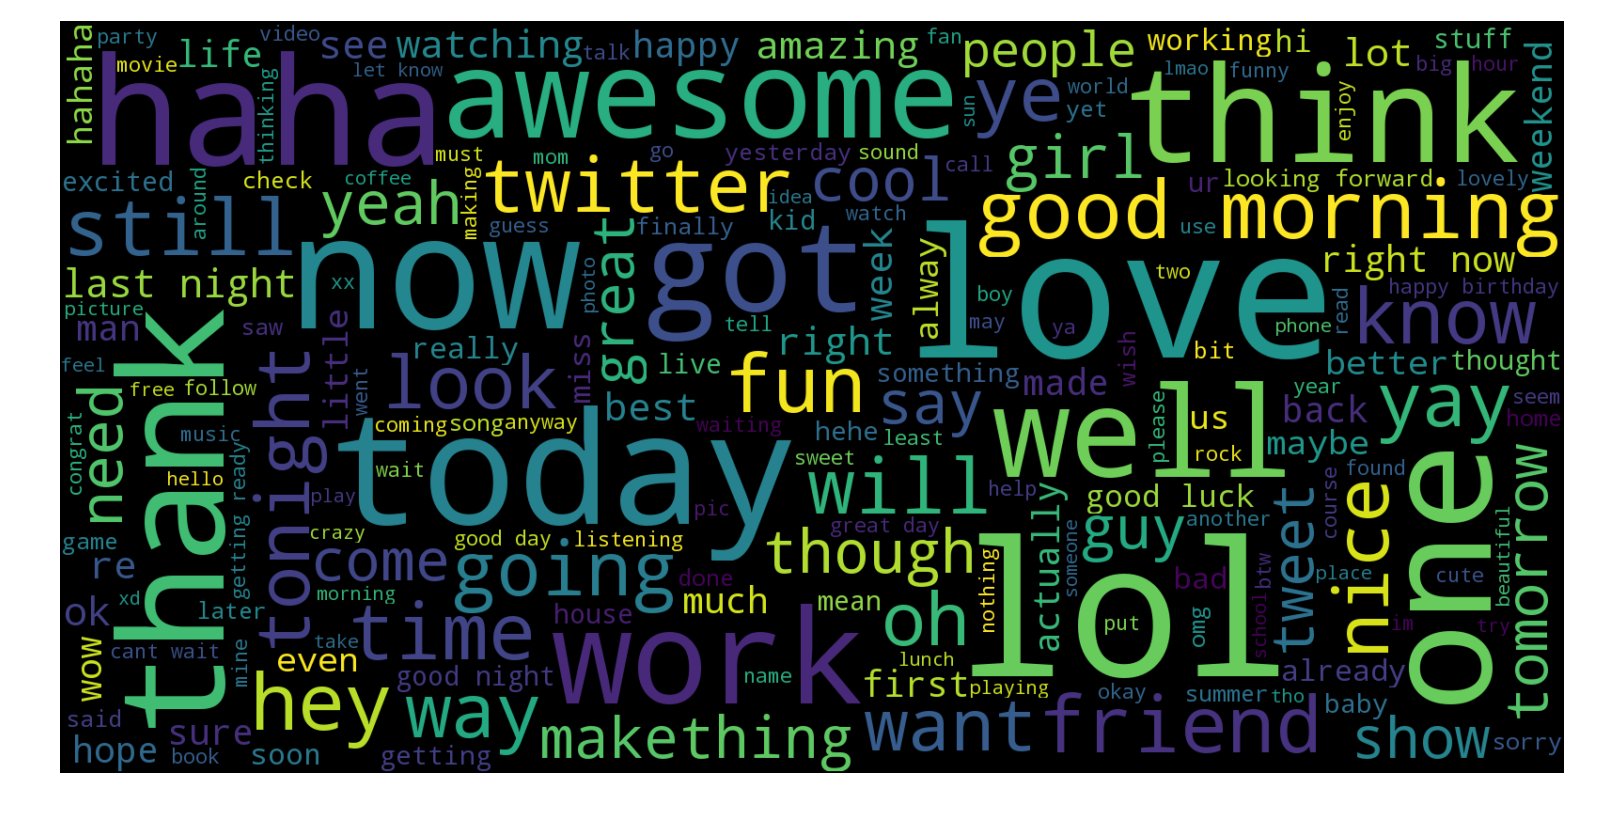

In [40]:
pos_tweets = my_df[my_df.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Interestingly, the word “work” was quite big in negative word cloud, but also quite big in positive word cloud. 

It might implies that many people express negative sentiment towards work, but also many people are positive about works.

# Preparation for more data visualisation

In order for me to implement a couple of data visualisation in the next step, I need term frequency data. What kind of words are used in the tweets, and how many times it is used in entire corpus. I used count vectorizer to calculate the term frequencies, even though the count vectorizer is also for fit, train and predict, but at this stage, I will just be extracting the term frequencies for the visualisation.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [46]:
len(cvec.get_feature_names())

271309

In [50]:
document_matrix = cvec.transform(my_df.text)
my_df[my_df.target == 0].tail()

text  target
798375    sick spending my day laying in bed listening to       0
798376                                      gmail is down       0
798377                        rest in peace farrah so sad       0
798378  urbane sounds like rival is flagging your ads ...       0
798379  has to resit exams over summer wishes he worke...       0

In [51]:
%time
neg_batches = np.linspace(0, 798379, 100).astype(int)
i = 0
neg_tf =[]
while i < len(neg_batches) - 1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(), axis=0)
    neg_tf.append(batch_result)
    if(i%10 == 0) | (i == len(neg_batches) - 2):
        print neg_batches[i+1], "entries' term frequency calculated"
    i += 1

Wall time: 0 ns
8064 entries' term frequency calculated
88708 entries' term frequency calculated
169353 entries' term frequency calculated
249997 entries' term frequency calculated
330641 entries' term frequency calculated
411286 entries' term frequency calculated
491930 entries' term frequency calculated
572574 entries' term frequency calculated
653219 entries' term frequency calculated
733863 entries' term frequency calculated
798379 entries' term frequency calculated


In [52]:
my_df.tail()

text  target
1596494  just woke up having no school is the best feel...       4
1596495  thewdb com very cool to hear old walt intervie...       4
1596496  are you ready for your mojo makeover ask me fo...       4
1596497  happy th birthday to my boo of alll time tupac...       4
1596498                               happy charitytuesday       4

In [53]:
%%time
pos_batches = np.linspace(798379,1596498,100).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(pos_batches)-2):
        print pos_batches[i+1],"entries' term freuquency calculated"
    i += 1

806440 entries' term freuquency calculated
887058 entries' term freuquency calculated
967676 entries' term freuquency calculated
1048295 entries' term freuquency calculated
1128913 entries' term freuquency calculated
1209531 entries' term freuquency calculated
1290149 entries' term freuquency calculated
1370767 entries' term freuquency calculated
1451385 entries' term freuquency calculated
1532003 entries' term freuquency calculated
1596498 entries' term freuquency calculated
Wall time: 13min 1s


In [56]:
neg = np.sum(neg_tf, axis=0)
pos = np.sum(pos_tf, axis=0)
term_freq_df = pd.DataFrame([neg, pos], columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

0   1
aa      168  97
aaa      97  55
aaaa     45  29
aaaaa    26  12
aaaaaa   16  12

In [57]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
to     313182    252600  565782
the    257953    266161  524114
my     190804    125981  316785
it     157491    147841  305332
and    153985    149692  303677
you    103865    198274  302139
not    194739     86877  281616
is     133533    111324  244857
in     115627    101297  216924
for     99044    117389  216433

The term frequency data frame has been created! And as you can see the most frequent words are all stop words like “to”, “the”, etc.

In [58]:
len(term_freq_df)

271309

In [59]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

# Zipf’s Law, data visualisation

https://en.wikipedia.org/wiki/Zipf%27s_law

Zipf’s Law states that a small number of words are used all the time, while the vast majority are used very rarely. There is nothing surprising about this, we know that we use some of the words very frequently, such as “the”, “of”, etc, and we rarely use the words like “aardvark” (aardvark is an animal species native to Africa). However, what’s interesting is that “given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc.”

Text(0.5,1,u'Top 500 tokens in the tweet')

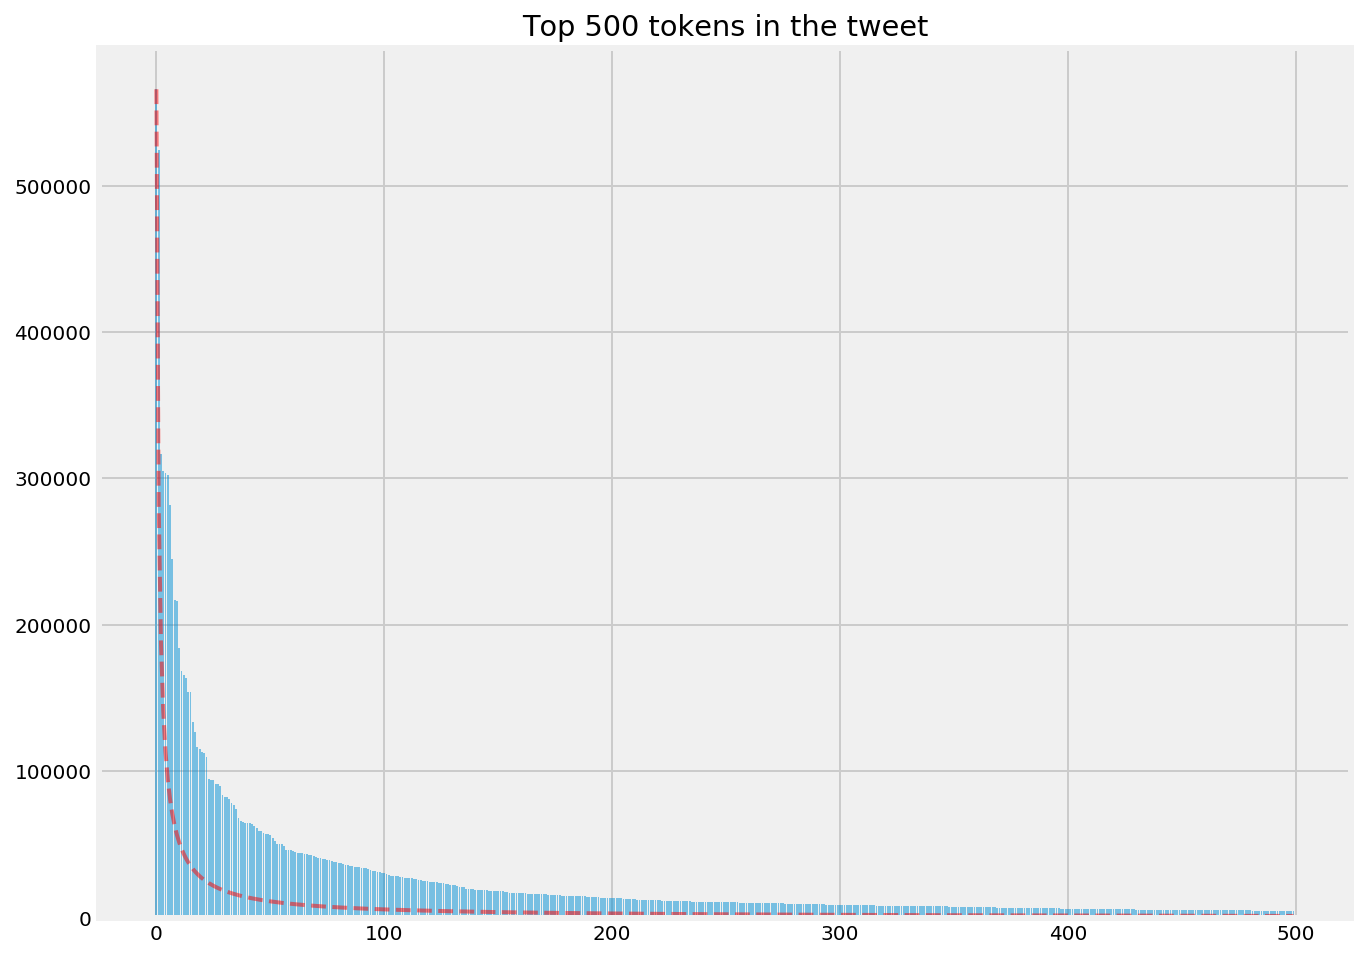

In [60]:
y_pos = np.arange(500)
plt.figure(figsize=(10, 8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False) ['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False) ['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel = 'frequency'
plt.title('Top 500 tokens in the tweet')

On the X-axis is the rank of the frequency from highest rank from left up to 500th rank to the right. Y-axis is the frequency observed in the corpus.


Another way to plot this is on a log-log graph, with X-axis being log(rank), Y-axis being log(frequency). By plotting on a log-log scale the result will yield roughly linear line on the graph.

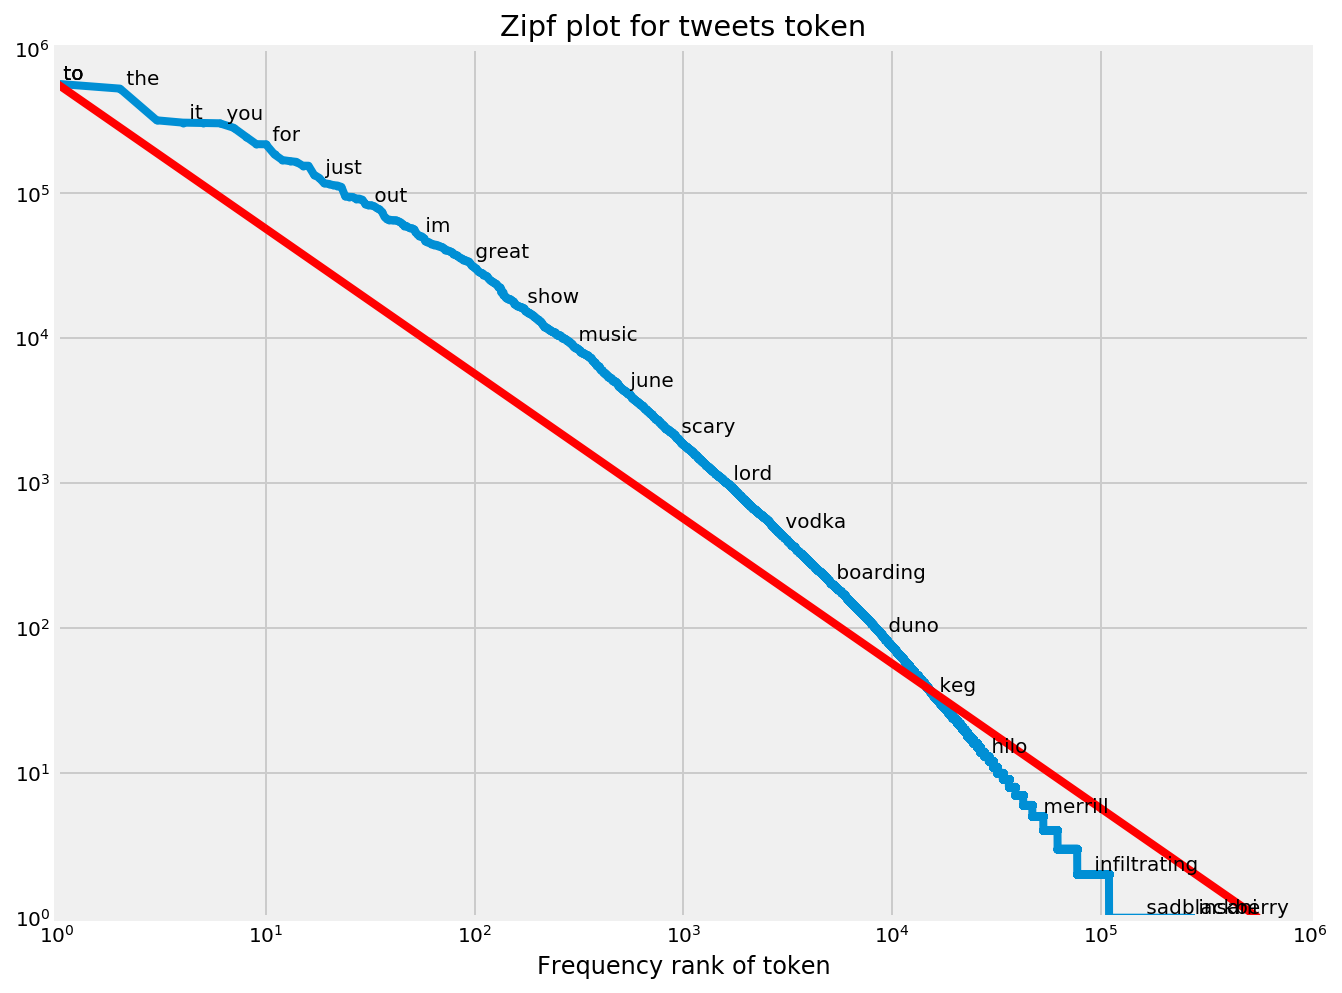

In [69]:
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(10, 8))
plt.ylim(1, 10**6)
plt.xlim(1, 10**6)
loglog(ranks, frequencies, marker='.')
plt.plot([1, frequencies[0]], [frequencies[0], 1], color='r')
title('Zipf plot for tweets token')
#ylabel("Absolute frequency of token")
xlabel("Frequency rank of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts) - 2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], verticalalignment='bottom', horizontalalignment='left')

# Tweets Tokens Visualisation

In [70]:
cvec = CountVectorizer(stop_words='english', max_features=10000)
cvec.fit(my_df.text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [71]:
document_matrix = cvec.transform(my_df.text)

In [72]:
%%time
neg_batches = np.linspace(0,798379,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print neg_batches[i+1],"entries' term freuquency calculated"
    i += 1
    
pos_batches = np.linspace(798379,1596498,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print pos_batches[i+1],"entries' term freuquency calculated"
    i += 1

neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

88708 entries' term freuquency calculated
177417 entries' term freuquency calculated
266126 entries' term freuquency calculated
354835 entries' term freuquency calculated
443543 entries' term freuquency calculated
532252 entries' term freuquency calculated
620961 entries' term freuquency calculated
709670 entries' term freuquency calculated
798379 entries' term freuquency calculated
887058 entries' term freuquency calculated
975738 entries' term freuquency calculated
1064418 entries' term freuquency calculated
1153098 entries' term freuquency calculated
1241778 entries' term freuquency calculated
1330458 entries' term freuquency calculated
1419138 entries' term freuquency calculated
1507818 entries' term freuquency calculated
1596498 entries' term freuquency calculated
Wall time: 51.4 s


Text(0.5,1,u'Top 50 tokens in negative tweets')

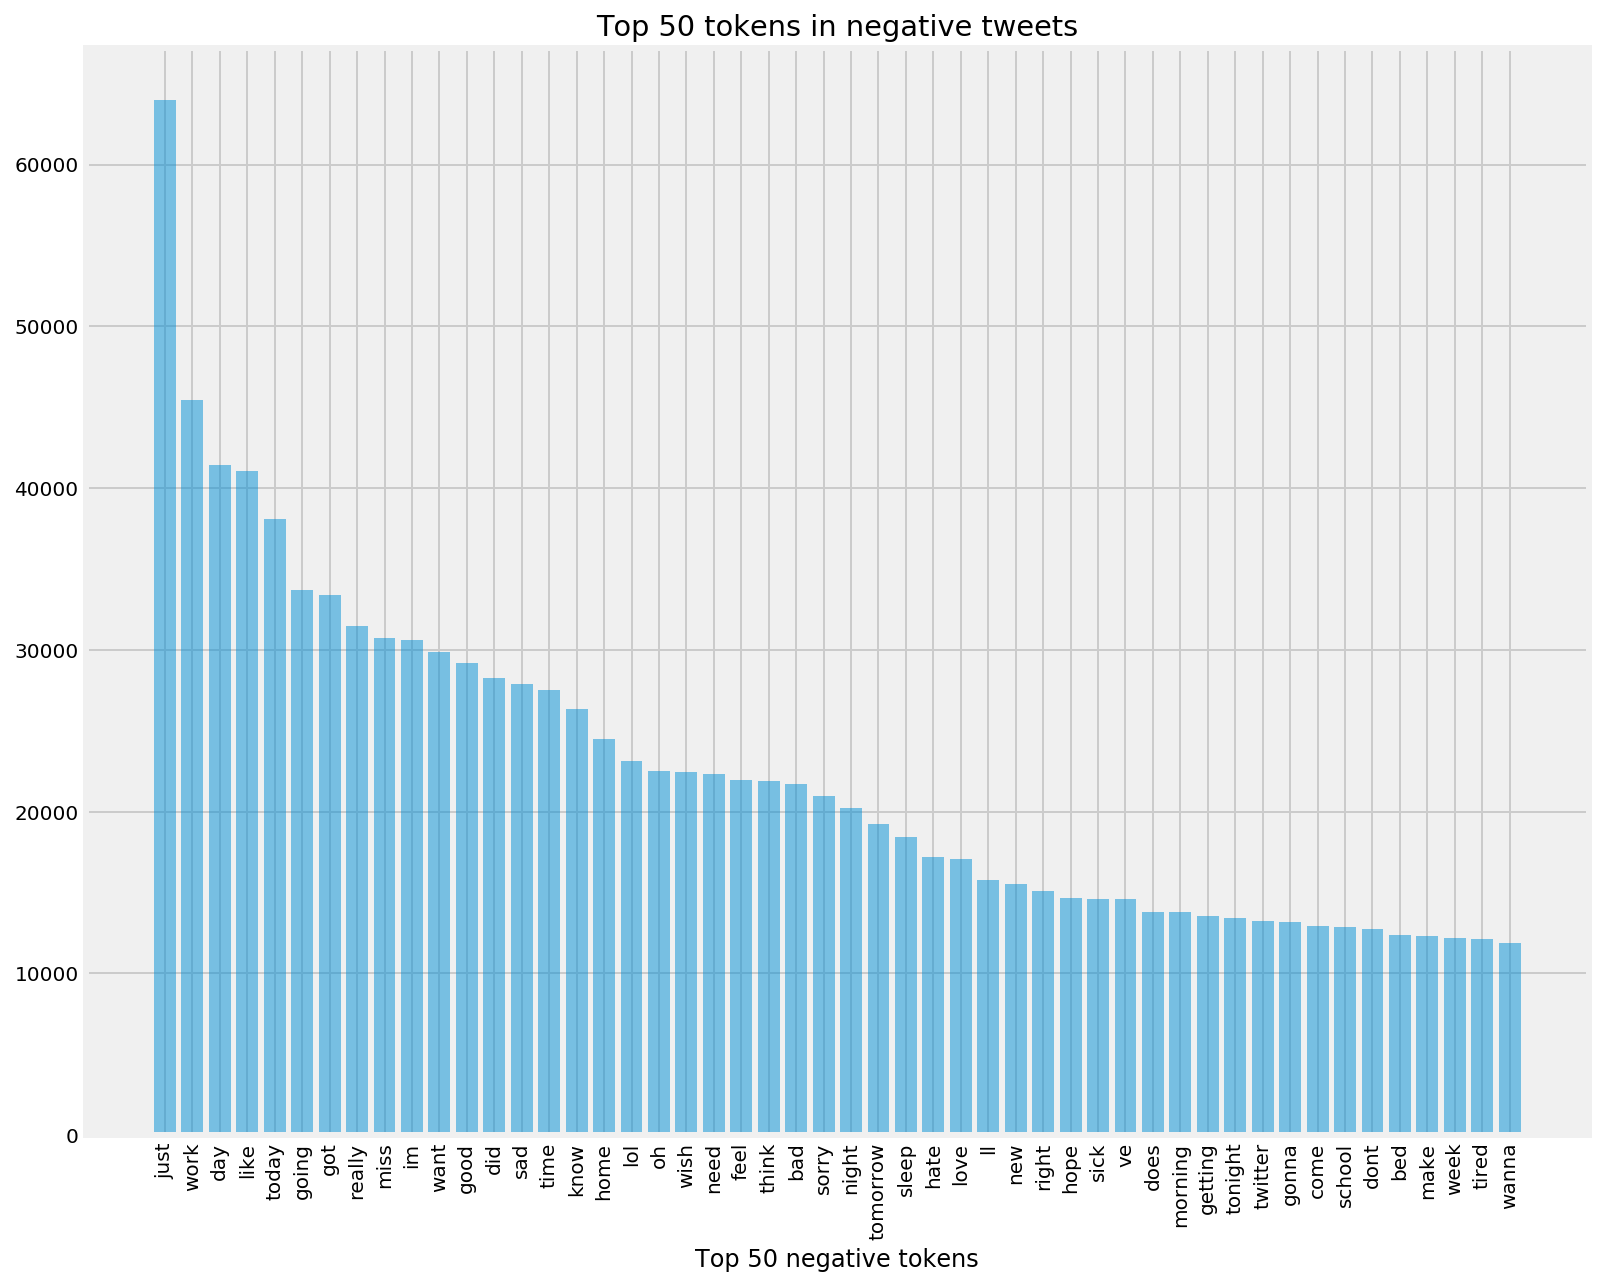

In [75]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
#plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5,1,u'Top 50 tokens in positive tweets')

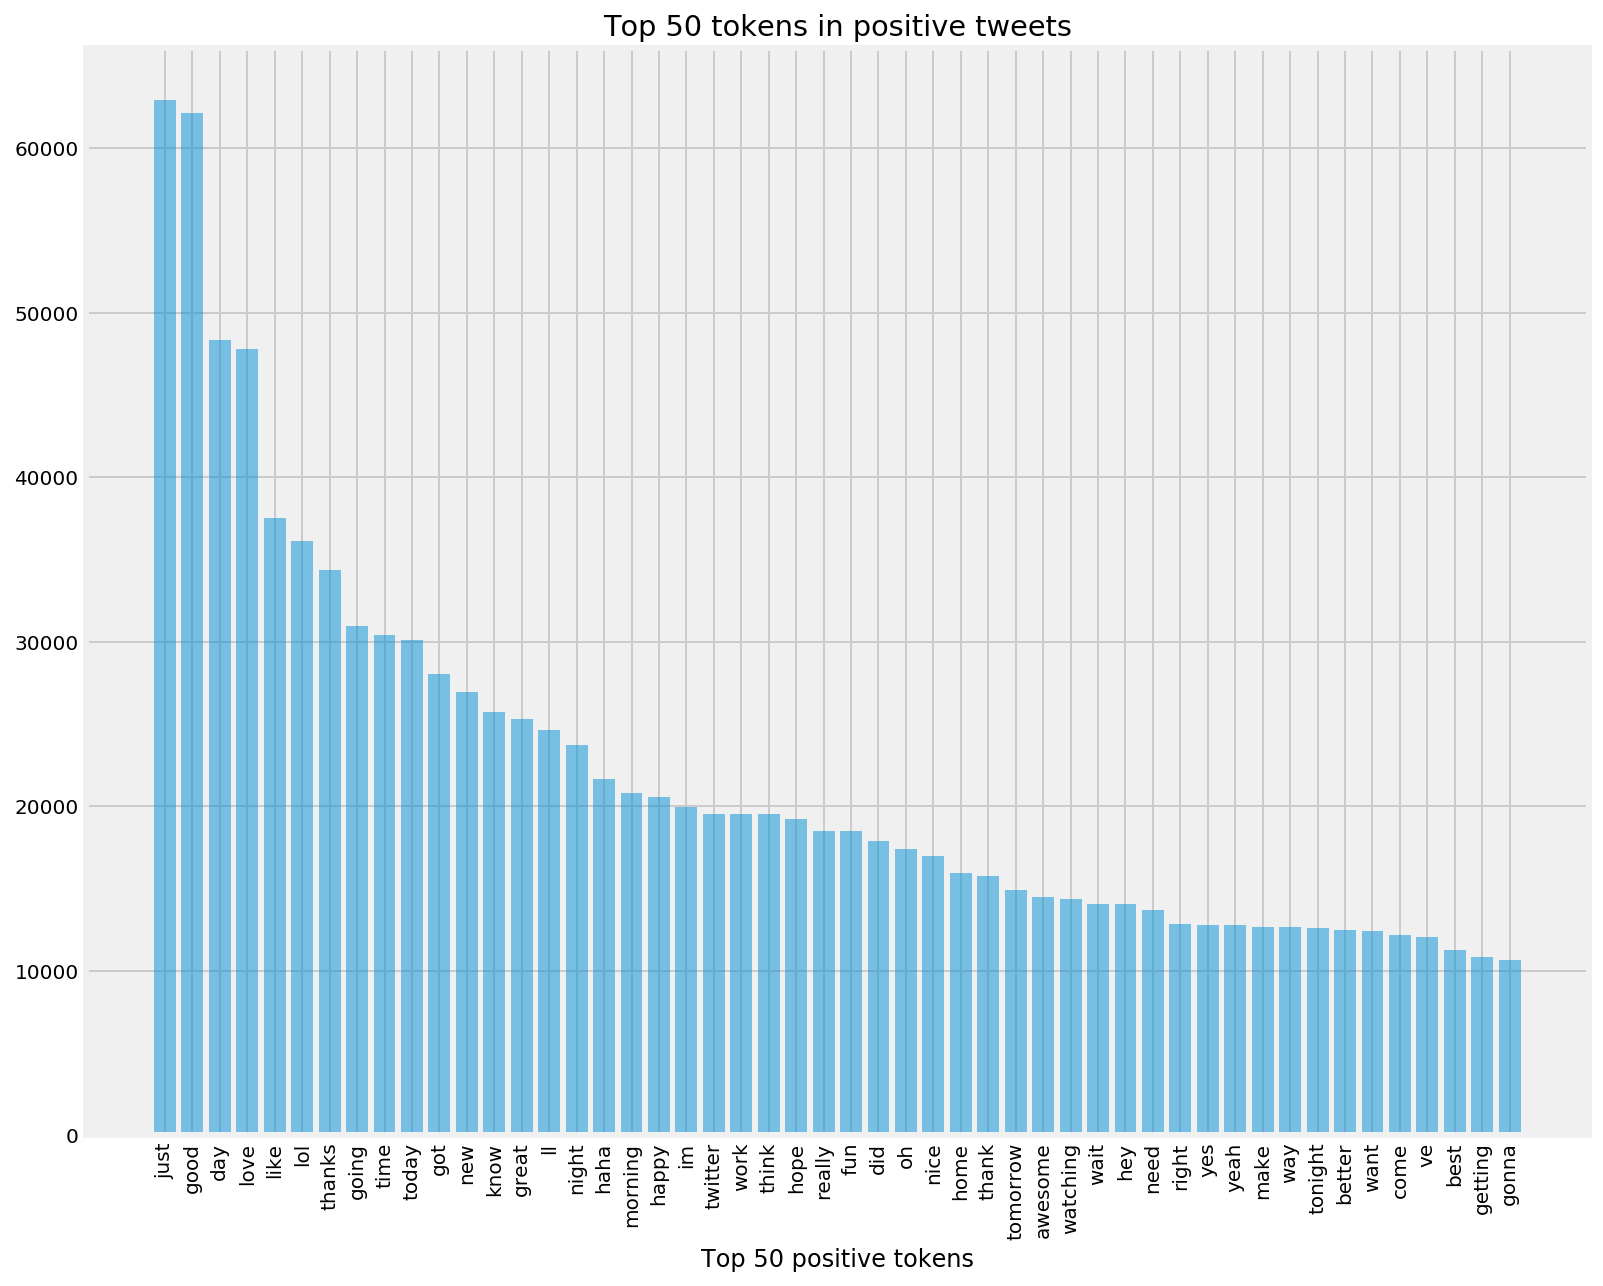

In [76]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
#plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

 Plot, negative frequency of a word on X-axis, and positive frequency on Y-axis

Text(0.5,1,u'Negative Frequency vs Positive Frequency')

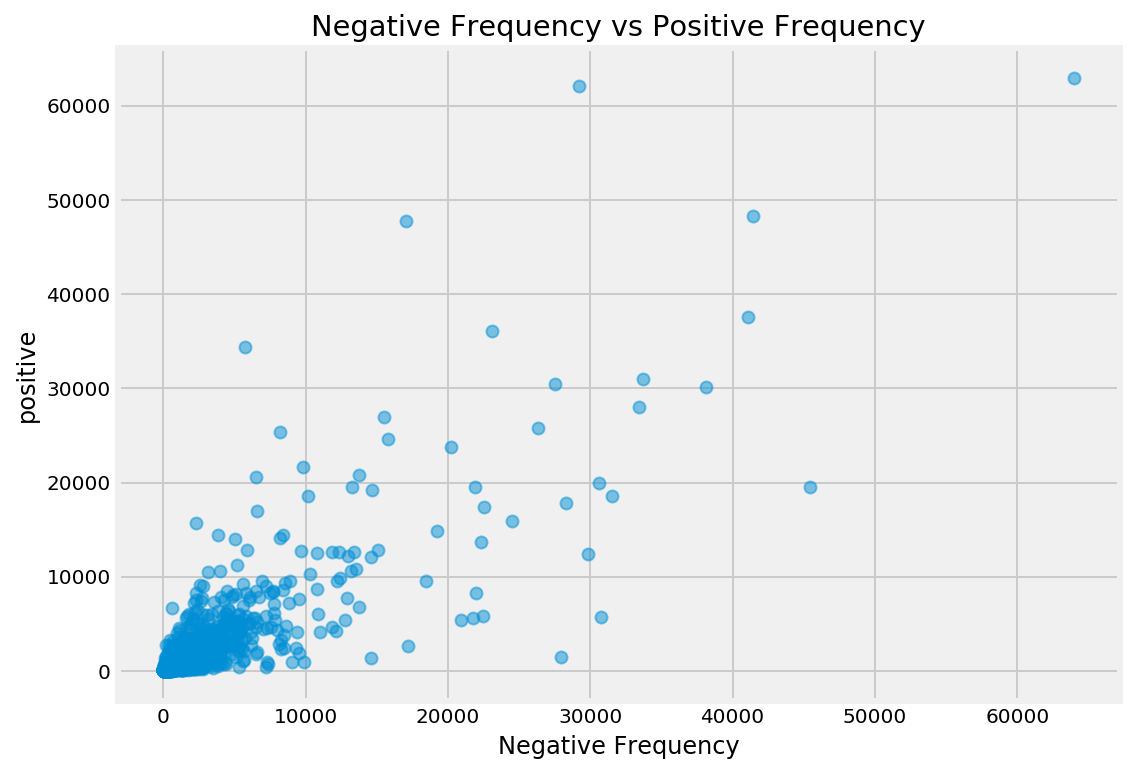

In [82]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
#plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

Most of the words are below 10,000 on both X-axis and Y-axis, and we cannot see a meaningful relation between negative and positive frequency.

Intuitively, if a word appears more often in one class compared to another, this can be a good measure of how much the word is meaningful to characterise the class.

In [83]:
term_freq_df2['pos_rate'] =  term_freq_df2['positive'] / term_freq_df2['total']
term_freq_df2['neg_rate'] =  term_freq_df2['negative'] / term_freq_df2['total']

In [86]:
term_freq_df2.sort_values(by='neg_rate', ascending=False).iloc[:10]

negative  positive  total  pos_rate  neg_rate
dontyouhate              106         0    106  0.000000  1.000000
pakcricket                82         0     82  0.000000  1.000000
neda                      98         0     98  0.000000  1.000000
isplayer                 210         0    210  0.000000  1.000000
inaperfectworld          189         0    189  0.000000  1.000000
happybdaykrisallen        71         0     71  0.000000  1.000000
fawcett                  380         0    380  0.000000  1.000000
sadd                     108         2    110  0.018182  0.981818
saddens                  102         2    104  0.019231  0.980769
farrah                   541        12    553  0.021700  0.978300

Words with highest pos_rate have zero frequency in the negative tweets, but overall frequency of these words are too low to think of it as a guideline for positive tweets.

In [87]:
term_freq_df2['pos_freq_rate'] = term_freq_df2['positive'] / term_freq_df2['positive'].sum()
term_freq_df2['neg_freq_rate'] = term_freq_df2['negative'] / term_freq_df2['negative'].sum()

In [88]:
term_freq_df2.sort_values(by='pos_freq_rate', ascending=False).iloc[:10]

negative  positive   total  pos_rate  neg_rate  pos_freq_rate  \
just       64006     62946  126952  0.495825  0.504175       0.014327   
good       29213     62122   91335  0.680155  0.319845       0.014140   
day        41456     48319   89775  0.538223  0.461777       0.010998   
love       17061     47780   64841  0.736879  0.263121       0.010875   
like       41052     37527   78579  0.477570  0.522430       0.008542   
lol        23123     36120   59243  0.609692  0.390308       0.008221   
thanks      5768     34378   40146  0.856324  0.143676       0.007825   
going      33690     30939   64629  0.478717  0.521283       0.007042   
time       27532     30438   57970  0.525065  0.474935       0.006928   
today      38118     30101   68219  0.441241  0.558759       0.006851   

        neg_freq_rate  
just         0.013939  
good         0.006362  
day          0.009028  
love         0.003715  
like         0.008940  
lol          0.005036  
thanks       0.001256  
going        0.007337  
time         0.005996  
today        0.008301

In [89]:
term_freq_df2.sort_values(by='neg_freq_rate', ascending=False).iloc[:10]

negative  positive   total  pos_rate  neg_rate  pos_freq_rate  \
just       64006     62946  126952  0.495825  0.504175       0.014327   
work       45422     19534   64956  0.300727  0.699273       0.004446   
day        41456     48319   89775  0.538223  0.461777       0.010998   
like       41052     37527   78579  0.477570  0.522430       0.008542   
today      38118     30101   68219  0.441241  0.558759       0.006851   
going      33690     30939   64629  0.478717  0.521283       0.007042   
got        33413     28040   61453  0.456284  0.543716       0.006382   
really     31496     18524   50020  0.370332  0.629668       0.004216   
miss       30737      5710   36447  0.156666  0.843334       0.001300   
im         30618     19977   50595  0.394841  0.605159       0.004547   

        neg_freq_rate  
just         0.013939  
work         0.009892  
day          0.009028  
like         0.008940  
today        0.008301  
going        0.007337  
got          0.007276  
really       0.006859  
miss         0.006694  
im           0.006668

But since pos_freq_rate/neg_freq_rate is just the frequency scaled over the total sum of the frequency, the rank of pos_freq_pct is exactly same as just the positive/negative frequency respectively.

What we can do now is to combine pos_rate, pos_freq_pct together to come up with a metric which reflects both pos_rate and pos_freq_pct. Even though both of these can take a value ranging from 0 to 1, pos_rate has much wider range actually spanning from 0 to 1, while all the pos_freq_pct values are squashed within the range smaller than 0.015. If we average these two numbers, pos_rate will be too dominant, and will not reflect both metrics effectively.

So here we use harmonic mean instead of arithmetic mean.

"Since the harmonic mean of a list of numbers tends strongly toward the least elements of the list, it tends (compared to the arithmetic mean) to mitigate the impact of large outliers and aggravate the impact of small ones."

In [94]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_rate']])
                                                          if x['pos_rate'] > 0 and x['pos_freq_rate'] > 0 else 0), axis=1)


term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_rate']])
                                                          if x['neg_rate'] > 0 and x['neg_freq_rate'] > 0 else 0), axis=1)

In [ ]:
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

In [96]:

term_freq_df2.sort_values(by='neg_hmean', ascending=False).iloc[:10]

negative  positive   total  pos_rate  neg_rate  pos_freq_rate  \
just       64006     62946  126952  0.495825  0.504175       0.014327   
work       45422     19534   64956  0.300727  0.699273       0.004446   
day        41456     48319   89775  0.538223  0.461777       0.010998   
like       41052     37527   78579  0.477570  0.522430       0.008542   
today      38118     30101   68219  0.441241  0.558759       0.006851   
going      33690     30939   64629  0.478717  0.521283       0.007042   
got        33413     28040   61453  0.456284  0.543716       0.006382   
really     31496     18524   50020  0.370332  0.629668       0.004216   
miss       30737      5710   36447  0.156666  0.843334       0.001300   
im         30618     19977   50595  0.394841  0.605159       0.004547   

        neg_freq_rate  pos_mean  neg_mean  pos_hmean  neg_hmean  
just         0.013939  0.027850  0.027127   0.027850   0.027127  
work         0.009892  0.008763  0.019507   0.008763   0.019507  
day          0.009028  0.021556  0.017710   0.021556   0.017710  
like         0.008940  0.016783  0.017579   0.016783   0.017579  
today        0.008301  0.013493  0.016359   0.013493   0.016359  
going        0.007337  0.013880  0.014470   0.013880   0.014470  
got          0.007276  0.012588  0.014361   0.012588   0.014361  
really       0.006859  0.008338  0.013570   0.008338   0.013570  
miss         0.006694  0.002578  0.013282   0.002578   0.013282  
im           0.006668  0.008991  0.013190   0.008991   0.013190

we can try next is to get the CDF (Cumulative Distribution Function) value of both pos_rate and pos_freq_pct. CDF can be explained as "distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x".

In [99]:
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_rate_normcdf'] = normcdf(term_freq_df2['pos_freq_rate'])
term_freq_df2['pos_hmean_normcdf'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_rate_normcdf']])
term_freq_df2.sort_values(by='pos_hmean_normcdf', ascending=False).iloc[:10]

negative  positive  total  pos_rate  neg_rate  pos_freq_rate  \
welcome       620      6702   7322  0.915324  0.084676       0.001525   
thank        2282     15737  18019  0.873356  0.126644       0.003582   
thanks       5768     34378  40146  0.856324  0.143676       0.007825   
awesome      3829     14475  18304  0.790811  0.209189       0.003295   
glad         2273      8255  10528  0.784100  0.215900       0.001879   
follow       2553      9154  11707  0.781925  0.218075       0.002084   
enjoy        1642      5876   7518  0.781591  0.218409       0.001337   
sweet        1621      5653   7274  0.777151  0.222849       0.001287   
yay          3171     10508  13679  0.768185  0.231815       0.002392   
hi           2176      7218   9394  0.768363  0.231637       0.001643   

         neg_freq_rate  pos_mean  neg_mean  pos_hmean  neg_hmean  \
welcome       0.000135  0.003046  0.000270   0.003046   0.000270   
thank         0.000497  0.007135  0.000990   0.007135   0.000990   
thanks        0.001256  0.015508  0.002490   0.015508   0.002490   
awesome       0.000834  0.006562  0.001661   0.006562   0.001661   
glad          0.000495  0.003749  0.000988   0.003749   0.000988   
follow        0.000556  0.004156  0.001109   0.004156   0.001109   
enjoy         0.000358  0.002670  0.000714   0.002670   0.000714   
sweet         0.000353  0.002569  0.000705   0.002569   0.000705   
yay           0.000691  0.004769  0.001377   0.004769   0.001377   
hi            0.000474  0.003279  0.000946   0.003279   0.000946   

         pos_rate_normcdf  pos_freq_rate_normcdf  pos_hmean_normcdf  
welcome          0.995718               0.999363           0.997537  
thank            0.990938               1.000000           0.995448  
thanks           0.987938               1.000000           0.993933  
awesome          0.967123               1.000000           0.983287  
glad             0.963877               0.999971           0.981593  
follow           0.962772               0.999996           0.981031  
enjoy            0.962599               0.997419           0.979700  
sweet            0.960246               0.996341           0.977961  
yay              0.955127               1.000000           0.977049  
hi               0.955234               0.999756           0.976988

In [100]:
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_rate_normcdf'] = normcdf(term_freq_df2['neg_freq_rate'])
term_freq_df2['neg_hmean_normcdf'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_rate_normcdf']])
term_freq_df2.sort_values(by='neg_hmean_normcdf', ascending=False).iloc[:10]

negative  positive  total  pos_rate  neg_rate  pos_freq_rate  \
sad          27911      1510  29421  0.051324  0.948676       0.000344   
hurts         7204       456   7660  0.059530  0.940470       0.000104   
sick         14620      1420  16040  0.088529  0.911471       0.000323   
sucks         9902       982  10884  0.090224  0.909776       0.000224   
poor          7333       719   8052  0.089295  0.910705       0.000164   
ugh           9056      1000  10056  0.099443  0.900557       0.000228   
missing       7282       991   8273  0.119787  0.880213       0.000226   
headache      5317       421   5738  0.073371  0.926629       0.000096   
hate         17208      2618  19826  0.132049  0.867951       0.000596   
miss         30737      5710  36447  0.156666  0.843334       0.001300   

          neg_freq_rate  pos_mean  neg_mean  pos_hmean  neg_hmean  \
sad            0.006078  0.000683  0.012079   0.000683   0.012079   
hurts          0.001569  0.000207  0.003132   0.000207   0.003132   
sick           0.003184  0.000644  0.006345   0.000644   0.006345   
sucks          0.002156  0.000446  0.004303   0.000446   0.004303   
poor           0.001597  0.000327  0.003188   0.000327   0.003188   
ugh            0.001972  0.000454  0.003936   0.000454   0.003936   
missing        0.001586  0.000450  0.003166   0.000450   0.003166   
headache       0.001158  0.000191  0.002313   0.000191   0.002313   
hate           0.003747  0.001186  0.007463   0.001186   0.007463   
miss           0.006694  0.002578  0.013282   0.002578   0.013282   

          pos_rate_normcdf  pos_freq_rate_normcdf  pos_hmean_normcdf  \
sad               0.002220               0.709102           0.004426   
hurts             0.002611               0.503418           0.005194   
sick              0.004536               0.693033           0.009013   
sucks             0.004680               0.609936           0.009289   
poor              0.004601               0.557195           0.009126   
ugh               0.005540               0.613484           0.010980   
missing           0.007948               0.611711           0.015692   
headache          0.003411               0.496236           0.006776   
hate              0.009808               0.868800           0.019397   
miss              0.014716               0.996649           0.029004   

          neg_rate_normcdf  neg_freq_rate_normcdf  neg_hmean_normcdf  
sad               0.997780               1.000000           0.998889  
hurts             0.997389               0.999741           0.998564  
sick              0.995464               1.000000           0.997727  
sucks             0.995320               0.999999           0.997654  
poor              0.995399               0.999798           0.997594  
ugh               0.994460               0.999995           0.997220  
missing           0.992052               0.999777           0.995899  
headache          0.996589               0.993786           0.995185  
hate              0.990192               1.000000           0.995072  
miss              0.985284               1.000000           0.992587

Now let's see how the values are converted on a plot. In order to compare, I will first plot neg_hmean vs pos_hmean, and neg_normcdf_hmean vs pos_normcdf_hmean.

Text(0.5,1,u'neg_hmean vs pos_hmean')

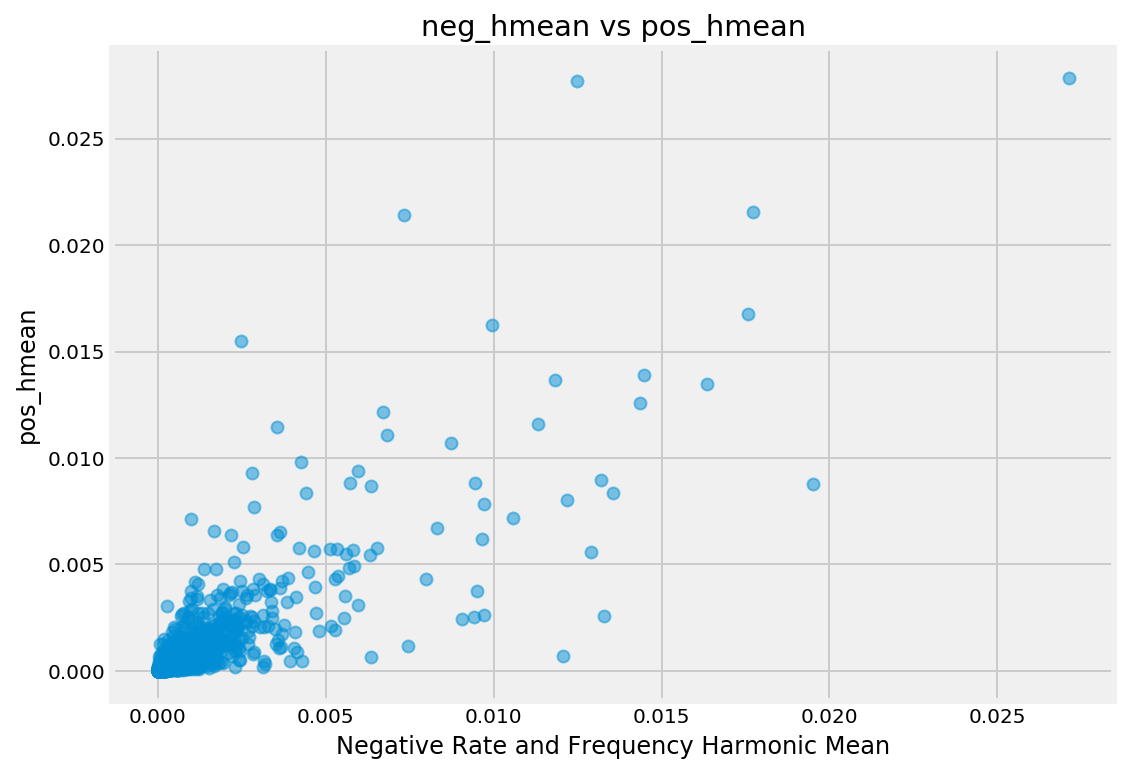

In [102]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
#plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5,1,u'neg_hmean_normcdf vs pos_hmean_normcdf')

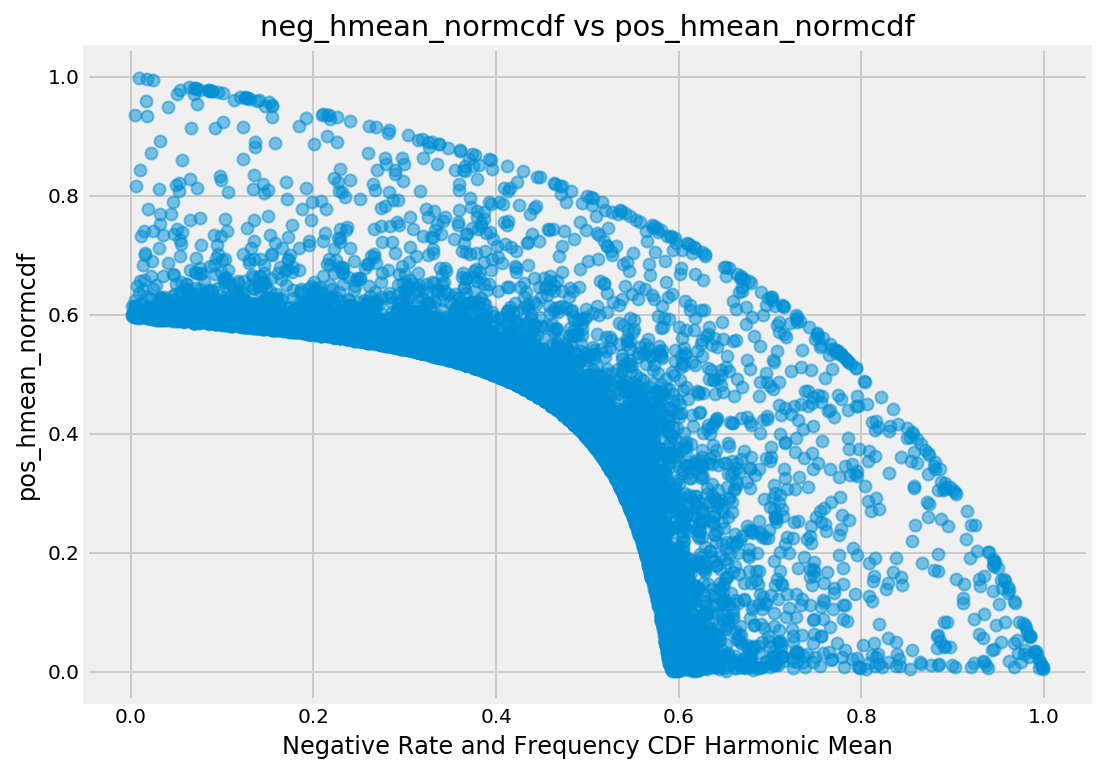

In [104]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean_normcdf", y="pos_hmean_normcdf",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
#plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_hmean_normcdf vs pos_hmean_normcdf')

It seems like the harmonic mean of rate CDF and frequency CDF has created an interesting pattern on the plot. If a data point is near to upper left corner, it is more positive, and if it is closer to the bottom right corner, it is more negative.

It is good that the metric has created some meaningful insight out of frequency, but with text data, showing every token as just a dot is lacking important information on which token each data point represents. With 10,000 points, it is difficult to annotate all of the points on the plot. For this part, I have tried several methods and came to a conclusion that it is not very practical or feasible to directly annotate data points on the plot.

So I took an alternative method of the interactive plot with Bokeh. Bokeh is an interactive visualisation library for Python, which creates graphics in style of D3.js. Bokeh can output the result in HTML format or also within the Jupyter Notebook. And below is the plot created with Bokeh.

In [106]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_hmean_normcdf), high=max(term_freq_df2.pos_hmean_normcdf))
p = figure(x_axis_label='neg_hmean_normcdf', y_axis_label='pos_hmean_normcdf')
p.circle('neg_hmean_normcdf', 'pos_hmean_normcdf', size=5, alpha=0.3, source=term_freq_df2, color={'field': 'pos_hmean_normcdf', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token', '@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...


With above Bokeh plot, you can see what token each data point represents by hovering over the points. For example, the points in the top left corner show tokens like "thank", "welcome", "congrats", etc. And some of the tokens in bottom right corner are "sad", "hurts", "died", "sore", etc. And the colour of each dot is organised in "Inferno256" colour map in Python, so yellow is the most positive, while black is the most negative, and the colour gradually goes from black to purple to orange to yellow, as it goes from negative to positive.

# Train / Dev / Test Split

Here I chose to split the data into three chunks: train, development, test.

    Train set: The sample of data used for learning
    
    Development set (Hold-out cross-validation set): The sample of data used to tune the parameters of a classifier, and provide an unbiased evaluation of a model.
    
    Test set: The sample of data used only to assess the performance of a final model.
    
The ratio I decided to split my data is 98/1/1, 98% of data as the training set, and 1% for the dev set, and the final 1% for the test set. 

In [107]:
x = my_df.text
y = my_df.target

In [109]:
from sklearn.cross_validation import train_test_split

SEED = 2000
x_train, x_validation_test, y_train, y_validation_test = train_test_split(x, y, test_size=0.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=SEED)

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [111]:
print "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 4]) / (len(x_train)*1.))*100)
print "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100)
print "Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 4]) / (len(x_test)*1.))*100)

Train set has total 1564569 entries with 50.00% negative, 50.00% positive
Validation set has total 15965 entries with 50.93% negative, 49.07% positive
Test set has total 15965 entries with 50.14% negative, 49.86% positive


# Baseline Benchmark

When comparing various machine learning algorithms, baseline provides a point of reference to compare. The most popular baseline is the Zero Rule (ZeroR). ZeroR classifier simply predicts the majority category (class). Although there is no predictability power in ZeroR, it is useful for determining a baseline performance as a benchmark for other classification methods. As you can see from the above validation set class division, the majority class is negative with 50.40%, which means if a classifier predicts negative for every validation data, it will get 50.40% accuracy.

Another baseline I wanted to compare the validation results with is TextBlob. Textblob is a python library for processing textual data. Apart from other useful tools such as POS tagging, n-gram, The package has built-in sentiment classification. This is a so-called out-of-the-box sentiment analysis tool, and in addition to the null accuracy, I will also keep in mind of the accuracy I get from TextBlob sentiment analysis to see how my model is performing.

In [130]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
%time

tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]
tbpred

Wall time: 0 ns


[1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,


In [131]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print "Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100)
print "-"*80
print "Confusion Matrix\n"
print confusion
print "-"*80
print "Classification Report\n"
print classification_report(y_validation, tbpred)

Accuracy Score: 16.74%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                   0                   0
negative                5459                2672
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

          0       0.77      0.33      0.46      8131
          1       0.00      0.00      0.00         0
          4       0.00      0.00      0.00      7834

avg / total       0.39      0.17      0.23     15965



# Feature Extraction


If we want to use text in machine learning algorithms, we’ll have to convert them to a numerical representation. One of the methods is called bag-of-words approach. The bag of words model ignores grammar and order of words. Once we have a corpus (text data) then first, a list of vocabulary is created based on the entire corpus. Then each document or data entry is represented as numerical vectors based on the vocabulary built from the corpus.
With count vectorizer, we merely count the appearance of the words in each text.


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

Below I define two functions to iteratively train on a different number of features, then check the accuracy of logistic regression on the validation set.

# Unigram

In [12]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.0) > 0.5:
        baseline_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.0)
    else:
        baseline_accuracy = 1.0 - (len(x_test[y_test == 0]) / (len(x_test)*1.0))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    ypred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, ypred)
    print "baseline accuracy: {0:.2f}%".format(baseline_accuracy*100)
    print "accuracy score: {0:.2f}%".format(accuracy*100)
    if accuracy > baseline_accuracy:
        print "model is {0:.2f}% more accurate than baseline accuracy".format((accuracy-baseline_accuracy)*100)
    elif accuracy == baseline_accuracy:
        print "model has the same accuracy with the baseline accuracy"
    else:
        print "model is {0:.2f}% less accurate than baseline accuracy".format((baseline_accuracy-accuracy)*100)
    print "train and test time: {0:.2f}s".format(train_test_time)
    print "-"*80
    return accuracy, train_test_time

In [14]:
cvec =  CountVectorizer()
logreg = LogisticRegression()
n_features = np.arange(10000, 100001, 10000)

In [15]:
def feature_accuracy_checker(vectorizer = cvec, n_features=n_features, stop_words = None, ngram_range=(1,1), classifier=logreg):
    result =[]
    print(classifier)
    print "\n"
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
        print "validation result for {} features".format(n)
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [149]:
%%time
print "RESULT FOR UNIGRAM WITHOUT STOP WORDS\n"
feature_result_wosw = feature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


validation result for 10000 features
baseline accuracy: 50.93%
accuracy score: 76.82%
model is 25.89% more accurate than baseline accuracy
train and test time: 65.68s
--------------------------------------------------------------------------------
validation result for 20000 features
baseline accuracy: 50.93%
accuracy score: 76.97%
model is 26.04% more accurate than baseline accuracy
train and test time: 79.99s
--------------------------------------------------------------------------------
validation result for 30000 features
baseline accuracy: 50.93%
accuracy score: 77.14%
model is 26.21% more accurate than baseline accuracy
train and test time: 104.09s
------------------------------

In [150]:
%%time
print "RESULT FOR UNIGRAM WITH STOP WORDS\n"
feature_result_ug = feature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


validation result for 10000 features
baseline accuracy: 50.93%
accuracy score: 79.64%
model is 28.71% more accurate than baseline accuracy
train and test time: 132.69s
--------------------------------------------------------------------------------
validation result for 20000 features
baseline accuracy: 50.93%
accuracy score: 79.74%
model is 28.81% more accurate than baseline accuracy
train and test time: 117.60s
--------------------------------------------------------------------------------
validation result for 30000 features
baseline accuracy: 50.93%
accuracy score: 79.78%
model is 28.85% more accurate than baseline accuracy
train and test time: 181.13s
-------------------------------

In [155]:
csv = 'term_freq_df.csv'
term_freq_df = pd.read_csv(csv,index_col=0)
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
to     313182    252600  565782
the    257953    266161  524114
my     190804    125981  316785
it     157491    147841  305332
and    153985    149692  303677
you    103865    198274  302139
not    194739     86877  281616
is     133533    111324  244857
in     115627    101297  216924
for     99044    117389  216433

In [152]:
from sklearn.feature_extraction import text

a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [153]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [154]:
%%time
print "RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n"
feature_result_wocsw = feature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


validation result for 10000 features
baseline accuracy: 50.93%
accuracy score: 78.65%
model is 27.72% more accurate than baseline accuracy
train and test time: 95.46s
--------------------------------------------------------------------------------
validation result for 20000 features
baseline accuracy: 50.93%
accuracy score: 78.76%
model is 27.83% more accurate than baseline accuracy
train and test time: 114.12s
--------------------------------------------------------------------------------
validation result for 30000 features
baseline accuracy: 50.93%
accuracy score: 78.67%
model is 27.74% more accurate than baseline accuracy
train and test time: 138.31

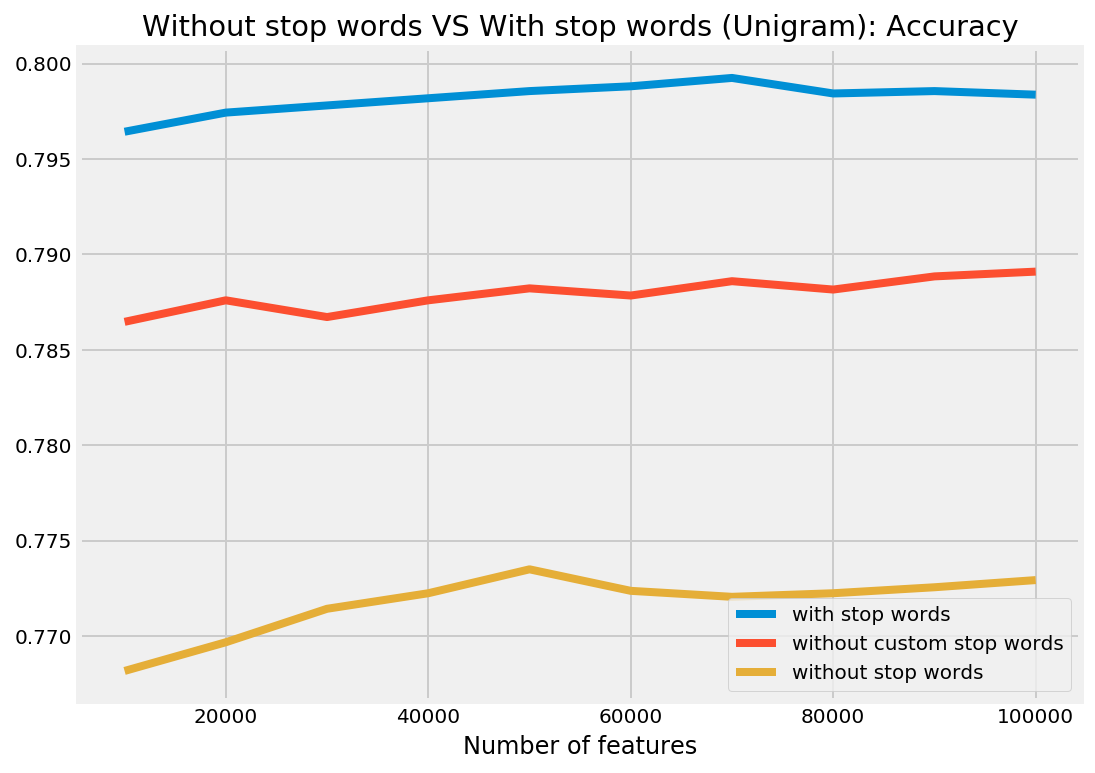

In [157]:
nfeature_result_ug = pd.DataFrame(feature_result_ug, columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeature_result_ug.nfeatures, nfeature_result_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
#plt.ylabel("Validation set accuracy")
plt.legend()

By looking at the evaluation result, removing stop words did not improve the model performance, but keeping the stop words yielded better performance. I wouldn't say that removing stopwords are not helping the model performance every time, but as empirical findings, in this particular setting, keeping the stop words improve the model performance.

# Bigram

According to Wikipedia, "n-gram is a contiguous sequence of n items from a given sequence of text or speech". In other words, n-grams are simply all combinations of adjacent words or letters of length n that you can find in your source text.

In [158]:
%%time
print "RESULT FOR BIGRAM WITH STOP WORDS\n"
feature_result_bg = feature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


validation result for 10000 features
baseline accuracy: 50.93%
accuracy score: 80.69%
model is 29.76% more accurate than baseline accuracy
train and test time: 217.35s
--------------------------------------------------------------------------------
validation result for 20000 features
baseline accuracy: 50.93%
accuracy score: 81.41%
model is 30.48% more accurate than baseline accuracy
train and test time: 250.99s
--------------------------------------------------------------------------------
validation result for 30000 features
baseline accuracy: 50.93%
accuracy score: 81.78%
model is 30.85% more accurate than baseline accuracy
train and test time: 238.72s
--------------------------------

In [160]:
%%time
print "RESULT FOR TRIGRAM WITH STOP WORDS\n"
feature_result_tg = feature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


validation result for 10000 features
baseline accuracy: 50.93%
accuracy score: 80.84%
model is 29.91% more accurate than baseline accuracy
train and test time: 422.38s
--------------------------------------------------------------------------------
validation result for 20000 features
baseline accuracy: 50.93%
accuracy score: 81.33%
model is 30.40% more accurate than baseline accuracy
train and test time: 415.33s
--------------------------------------------------------------------------------
validation result for 30000 features
baseline accuracy: 50.93%
accuracy score: 81.68%
model is 30.75% more accurate than baseline accuracy
train and test time: 459.13s
-------------------------------

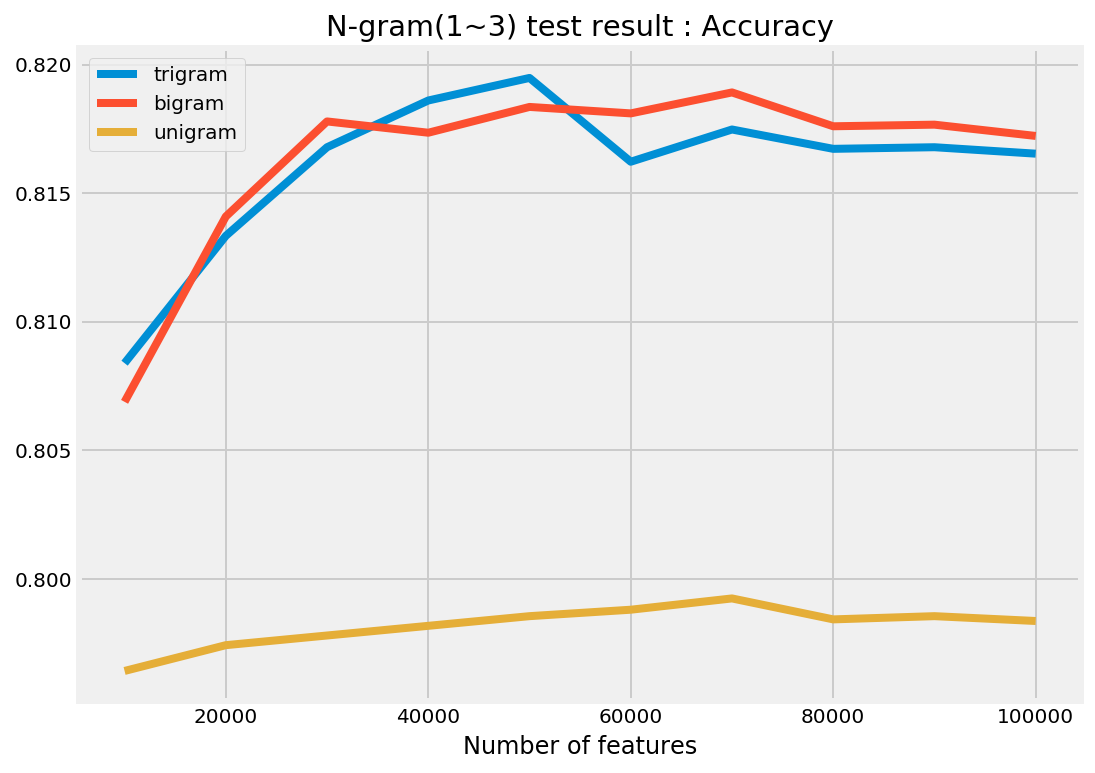

In [161]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
#plt.ylabel("Validation set accuracy")
plt.legend()

The best validation set accuracy for each n-gram is as below.

unigram: 80,000 & 90,000 features at validation accuracy 80.28%

bigram: 70,000 features at validation accuracy 82.25%

trigram: 80,000 features at validation accuracy 82.44%

In [162]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print "null accuracy: {0:.2f}%".format(null_accuracy*100)
    print "accuracy score: {0:.2f}%".format(accuracy*100)
    if accuracy > null_accuracy:
        print "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100)
    elif accuracy == null_accuracy:
        print "model has the same accuracy with the null accuracy"
    else:
        print "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100)
    print "-"*80
    print "Confusion Matrix\n"
    print confusion
    print "-"*80
    print "Classification Report\n"
    print classification_report(y_test, y_pred, target_names=['negative','positive'])

In [164]:
%%time
ug_cvec = CountVectorizer(max_features=80000)
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', logreg)
    ])
train_test_and_evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 50.93%
accuracy score: 79.84%
model is 28.91% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6373                   0
positive                   0                   0
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.81      0.78      0.80      8131
   positive       0.78      0.81      0.80      7834

avg / total       0.80      0.80      0.80     15965

Wall time: 3min 28s


In [165]:
%%time
bg_cvec = CountVectorizer(max_features=70000,ngram_range=(1, 2))
bg_pipeline = Pipeline([
        ('vectorizer', bg_cvec),
        ('classifier', logreg)
    ])
train_test_and_evaluate(bg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 50.93%
accuracy score: 81.89%
model is 30.96% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6535                   0
positive                   0                   0
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.83      0.80      0.82      8131
   positive       0.80      0.83      0.82      7834

avg / total       0.82      0.82      0.82     15965

Wall time: 5min 58s


In [166]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', logreg)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 50.93%
accuracy score: 81.67%
model is 30.74% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6479                   0
positive                   0                   0
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.84      0.80      0.82      8131
   positive       0.80      0.84      0.82      7834

avg / total       0.82      0.82      0.82     15965

Wall time: 9min 29s



From the above classification reports, we can see that model has slightly higher precision in negative class and higher recall in positive class. But this averages out by calculating the F1 score, and for both classes, we get the almost same F1 score for both positive and negative class.

# TFIDF Vectorizer

TF-IDF is another way to convert textual data to a numeric form and is short for Term Frequency-Inverse Document Frequency. The vector value it yields is the product of these two terms; TF and IDF.

In [2]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv, index_col = 0)
my_df.head()

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [3]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596499 entries, 0 to 1596498
Data columns (total 2 columns):
text      1596499 non-null object
target    1596499 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
x = my_df.text
y = my_df.target

In [5]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
tvec = TfidfVectorizer()

In [15]:
%%time
print "RESULT FOR UNIGRAM WITH STOP WORDS (TFIDF) \n"
feature_result_ugt = feature_accuracy_checker(vectorizer=tvec)

RESULT FOR UNIGRAM WITH STOP WORDS (TFIDF) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


validation result for 10000 features
baseline accuracy: 50.93%
accuracy score: 79.84%
model is 28.91% more accurate than baseline accuracy
train and test time: 53.38s
--------------------------------------------------------------------------------
validation result for 20000 features
baseline accuracy: 50.93%
accuracy score: 79.93%
model is 29.00% more accurate than baseline accuracy
train and test time: 59.04s
--------------------------------------------------------------------------------
validation result for 30000 features
baseline accuracy: 50.93%
accuracy score: 79.94%
model is 29.01% more accurate than baseline accuracy
train and test time: 60.46s
-------------------------

In [16]:
%%time
print "RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)\n"
feature_result_bgt = feature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


validation result for 10000 features
baseline accuracy: 50.93%
accuracy score: 80.97%
model is 30.04% more accurate than baseline accuracy
train and test time: 105.14s
--------------------------------------------------------------------------------
validation result for 20000 features
baseline accuracy: 50.93%
accuracy score: 81.45%
model is 30.52% more accurate than baseline accuracy
train and test time: 108.45s
--------------------------------------------------------------------------------
validation result for 30000 features
baseline accuracy: 50.93%
accuracy score: 81.60%
model is 30.67% more accurate than baseline accuracy
train and test time: 115.54s
------------------------

In [17]:
%%time
print "RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n"
feature_result_tgt = feature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


validation result for 10000 features
baseline accuracy: 50.93%
accuracy score: 80.91%
model is 29.98% more accurate than baseline accuracy
train and test time: 206.02s
--------------------------------------------------------------------------------
validation result for 20000 features
baseline accuracy: 50.93%
accuracy score: 81.54%
model is 30.61% more accurate than baseline accuracy
train and test time: 214.86s
--------------------------------------------------------------------------------
validation result for 30000 features
baseline accuracy: 50.93%
accuracy score: 81.70%
model is 30.77% more accurate than baseline accuracy
train and test time: 220.80s
-----------------------

TypeError: list indices must be integers, not str

It seems like TFIDF vectorizer is yielding better results when fed to logistic regression. Let's plot the results from count vectorizer together with TFIDF vectorizer.

In [33]:
features_plot_tgt = pd.DataFrame(feature_result_tgt, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])
features_plot_bgt = pd.DataFrame(feature_result_bgt, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])
features_plot_ugt = pd.DataFrame(feature_result_ugt, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])


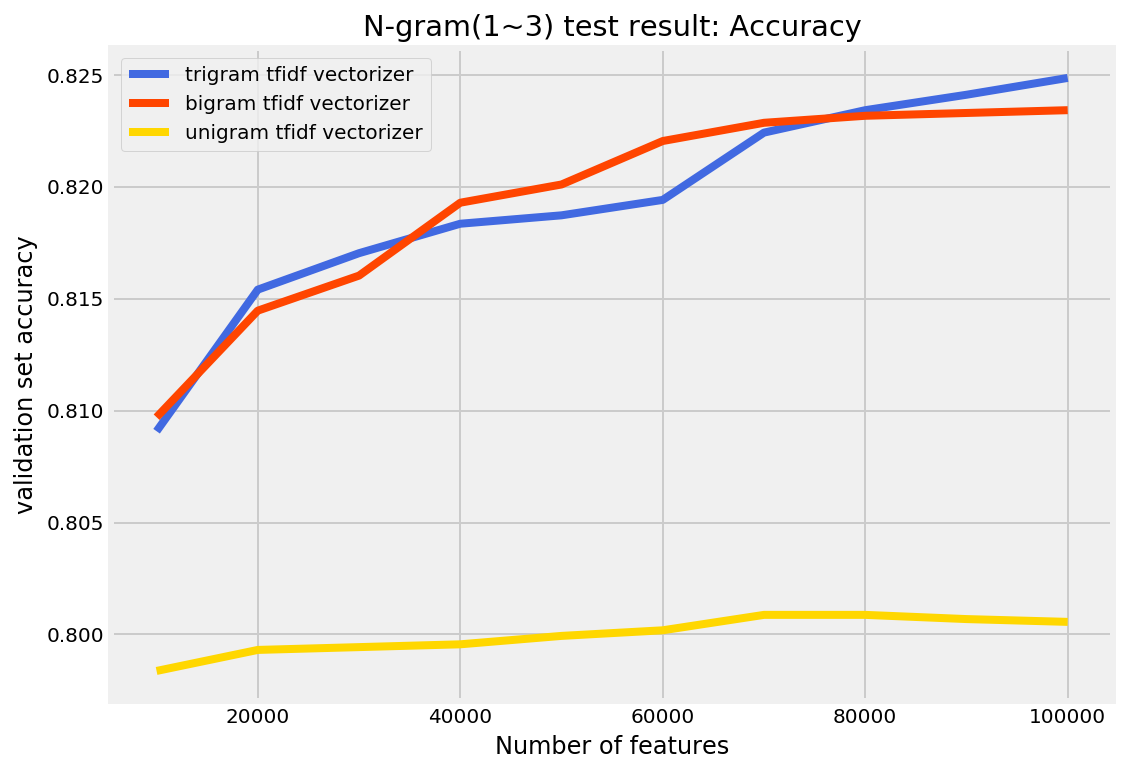

In [36]:

plt.figure(figsize=(8,6))
plt.plot(features_plot_tgt.nfeatures, features_plot_tgt.validation_accuracy, label='trigram tfidf vectorizer', color='royalblue')
plt.plot(features_plot_bgt.nfeatures, features_plot_bgt.validation_accuracy, label='bigram tfidf vectorizer', color='orangered')
plt.plot(features_plot_ugt.nfeatures, features_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer', color='gold')
plt.title('N-gram(1~3) test result: Accuracy')
plt.xlabel('Number of features')
plt.ylabel('validation set accuracy')
plt.legend()

From above chart, we can see including bigram and trigram boost the model performance both in count vectorizer and TFIDF vectorizer. And for every case of unigram to trigram, TFIDF yields better results than count vectorizer.

# Algorithms Comparison

The best result I can get with logistic regression was by using TFIDF vectorizer of 100,000 features including up to trigram. With this I will first fit various different models and compare their validation results, then I will build an ensemble (voting) classifier with top 5 models.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.feature_selection import SelectFromModel

In [23]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False))),
             ('classification', LinearSVC(penalty='l2'))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
]

zipped_clf = zip(names, classifiers)

In [24]:
tvec = TfidfVectorizer()

In [25]:
def classifier_comparator(vectorizer=tvec, n_features = 10000, stop_words =None, ngram_range=(1,1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n, clf in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
        print "validation result for  {}".format(n)
        print clf
        clf_accucary, tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, clf_accucary, tt_time))
    return result

In [ ]:
%%time
triagram_result = classifier_comparator(n_features=100000, ngram_range=(1,3))

validation result for  Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
baseline accuracy: 50.93%
accuracy score: 82.49%
model is 31.56% more accurate than baseline accuracy
train and test time: 250.28s
--------------------------------------------------------------------------------
validation result for  Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
baseline accuracy: 50.93%
accuracy score: 81.60%
model is 30.67% more accurate than baseline accuracy
train and test time: 740.88s
--------------------------------------------------------------------------------
validation result f

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


baseline accuracy: 50.93%
accuracy score: 75.68%
model is 24.75% more accurate than baseline accuracy
train and test time: 217.67s
--------------------------------------------------------------------------------
validation result for  Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


baseline accuracy: 50.93%
accuracy score: 79.49%
model is 28.56% more accurate than baseline accuracy
train and test time: 222.02s
--------------------------------------------------------------------------------
validation result for  Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
baseline accuracy: 50.93%
accuracy score: 73.09%
model is 22.16% more accurate than baseline accuracy
train and test time: 218.25s
--------------------------------------------------------------------------------
Wall time: 1h 9min 56s


In [26]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print "Validation result for {}".format(label)
    print clf
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
baseline accuracy: 50.93%
accuracy score: 82.49%
model is 31.56% more accurate than baseline accuracy
train and test time: 221.00s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
baseline accuracy: 50.93%
accuracy score: 81.80%
model is 30.87% more accurate than baseline accuracy
train and test time: 694.54s
--------------------------------------------------------------------------------
Validation result for

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


baseline accuracy: 50.93%
accuracy score: 79.42%
model is 28.49% more accurate than baseline accuracy
train and test time: 179.92s
--------------------------------------------------------------------------------
Validation result for Ensemble
VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svc', Linear...   n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)
baseline accuracy: 50.93%
accuracy score: 82.10%
model is 31.17% more accurate than baseline accuracy
train and test time: 788.91s
--------------------------------------------------------------------------------


# Lexical Approach

In [17]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv, index_col = 0)
my_df.head()

my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

x = my_df.text
y = my_df.target

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596499 entries, 0 to 1596498
Data columns (total 2 columns):
text      1596499 non-null object
target    1596499 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [18]:
from sklearn.cross_validation import train_test_split

SEED = 2000
x_train, x_validation_test, y_train, y_validation_test = train_test_split(x, y, test_size=0.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=SEED)

In [32]:
x_train

566905     remember when mobileme launched they delayed i...
1566482    dina omg harsh weather where are you my strawb...
469368     am in my office at the technology centre today...
482033                postponed my exam to different weekend
286066     oh god my dad came home from air france last w...
51734                            do not say that pray for me
220614                                   rearranging my room
1316829            yes it been while was underground for bit
974639     there were so many people there it was awesome...
960962     you know those hair wraps with the yarn that y...
343632                                                 early
1533226    no matter where life takes me will always know...
663655         just finished season of the oc shed few tears
577063                          massive headache save meeeee
514657                    just got home from school so tired
1028991    have the most amazing boyfriend sigh until tom...
387803           nothing

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(max_features = 10000)
cvec.fit(x_train)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [24]:
neg_train = x_train[y_train == 0]
pos_train = x_train[y_train == 1]

neg_doc_matrix = cvec.transform(neg_train)
pos_doc_matrix = cvec.transform(pos_train)

In [29]:
%%time
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)

[[0 0 0 ..., 0 0 0]]
Wall time: 17 ms


In [22]:
from scipy.stats import hmean, norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

In [31]:
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg, pos], columns=cvec.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df['pos_rate'] = (term_freq_df['positive']) * (1./term_freq_df['total'])
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] * 1./term_freq_df['positive'].sum()
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])

term_freq_df['pos_normcdf_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate_normcdf'], x['pos_freq_pct_normcdf']])
                                                          if x['pos_rate_normcdf'] > 0 and x['pos_freq_pct_normcdf'] > 0 else 0), axis=1)
#term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
term_freq_df.sort_values(by='positive', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct  \
aa              165         0    165       0.0           NaN   
postponed       185         0    185       0.0           NaN   
post           2116         0   2116       0.0           NaN   
postcard         24         0     24       0.0           NaN   
posted          673         0    673       0.0           NaN   
poster          143         0    143       0.0           NaN   
posters          96         0     96       0.0           NaN   
posting         306         0    306       0.0           NaN   
postman          49         0     49       0.0           NaN   
posts           351         0    351       0.0           NaN   

           pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  
aa                      NaN                   NaN                  0  
postponed               NaN                   NaN                  0  
post                    NaN                   NaN                  0  
postcard                NaN                   NaN                  0  
posted                  NaN                   NaN                  0  
poster                  NaN                   NaN                  0  
posters                 NaN                   NaN                  0  
posting                 NaN                   NaN                  0  
postman                 NaN                   NaN                  0  
posts                   NaN                   NaN                  0

# Doc2Vec

Doc2vec uses the same logic as word2vec, but apply this to document level.

"every paragraph is mapped to a unique vector, represented by a column in matrix D and every word is also mapped to a unique vector, represented by a column in matrix W. The paragraph vector and word vectors are averaged or concatenated to predict the next word in a context…The paragraph token can be thought of as another word. It acts as a memory that remembers what is missing from the current context — or the topic of the paragraph."

Below are the methods I used to get the vectors for each tweet.

DBOW (Distributed Bag of Words)

DMC (Distributed Memory Concatenated)

DMM (Distributed Memory Mean)

DBOW + DMC

DBOW + DMM

With above vectors, I fit a simple logistic regression model and evaluated the result on the validation set.

In [2]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [11]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596499 entries, 0 to 1596498
Data columns (total 2 columns):
text      1596499 non-null object
target    1596499 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [12]:
x = my_df.text
y = my_df.target

In [13]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
from tqdm import tqdm
tqdm.pandas(desc='Progress-bar')
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [16]:
def labelize_tweets_ug(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s'%i]))
    return result

In [17]:
all_x = pd.concat([x_train, x_validation, x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [18]:
len(all_x_w2v)

1596499

In [19]:
all_x_w2v

[TaggedDocument(words=['remember', 'when', 'mobileme', 'launched', 'they', 'delayed', 'it', 'day', 'and', 'it', 'only', 'worked', 'sporadically', 'once', 'it', 'did', 'start'], tags=['all_566905']),
 TaggedDocument(words=['dina', 'omg', 'harsh', 'weather', 'where', 'are', 'you', 'my', 'strawberries', 'lasted', 'all', 'year', 'had', 'tomato', 'plant', 'in', 'january'], tags=['all_1566482']),
 TaggedDocument(words=['am', 'in', 'my', 'office', 'at', 'the', 'technology', 'centre', 'today', 'must', 'get', 'some', 'marking', 'done', 'today'], tags=['all_469368']),
 TaggedDocument(words=['postponed', 'my', 'exam', 'to', 'different', 'weekend'], tags=['all_482033']),
 TaggedDocument(words=['oh', 'god', 'my', 'dad', 'came', 'home', 'from', 'air', 'france', 'last', 'week', 'thank', 'god', 'and', 'pray', 'for', 'those', 'who', 'stuck', 'in', 'that', 'plane'], tags=['all_286066']),
 TaggedDocument(words=['do', 'not', 'say', 'that', 'pray', 'for', 'me'], tags=['all_51734']),
 TaggedDocument(words=[

# DBOW (Distributed Bag of Words)

In [20]:
cores = multiprocessing.cpu_count()
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3687063.92it/s]


According to Gensim, "One caveat of the way this algorithm runs is that, since the learning rate decrease over the course of iterating over the data, labels which are only seen in a single LabeledSentence during training will only be trained with a fixed learning rate. This frequently produces less than optimal results."

Below iteration implement explicit multiple-pass, alpha-reduction approach with added shuffling.

In [21]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.02
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3704174.06it/s]


KeyboardInterrupt: 

In [ ]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix ='all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [ ]:
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

In [ ]:
clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)

In [ ]:
clf.score(validation_vecs_dbow, y_validation)

Even though the DBOW model doesn't learn the meaning of the individual words, but as features to feed to a classifier, it seems like it's doing its job.

But the result doesn't seem to excel count vectorizer or Tfidf vectorizer. It might not be a direct comparison since either count vectorizer of Tfidf vectorizer uses a large number of features to represent a tweet, but in this case, a vector for each tweet has only 200 dimensions.

In [ ]:
model_ug_dbow.save('d2v_model_ug_dbow.doc2vec')
model_ug_dbow = Doc2Vec.load('d2v_model_ug_dbow.doc2vec')

In [ ]:
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# Distributed Memory (concatenated)

In [ ]:
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, windows=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

In [ ]:
%%time
for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.02
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

In [ ]:
model_ug_dmc.save('d2v_model_ug_dmc.doc2vec')
model_ug_dmc = Doc2Vec.load('d2v_model_ug_dmc.doc2vec')

What's nice about Doc2Vec is that after training you can retrieve not only document vectors but also individual word vectors as well. Note, however, that a Doc2Vec DBOW model doesn't learn semantic word vectors, so the word vectors you retrieve from pure DBOW model will be the automatic randomly-initialized vectors, with no meaning. But with DM model, you can see the semantic relationship between words. Let's see what word vectors it has learned through training.

In [ ]:
model_ug_dmc.most_similar('good')

In [ ]:
model_ug_dmc.most_similar('happy')

In [ ]:
model_ug_dmc.most_similar('facebook')

In [ ]:
model_ug_dmc.most_similar(positive=['bigger', 'small'], negative=['big'])

The model successfully catches the comparative form of "small", on feeding the word "big" and "bigger". The above line of code is like asking the model to add the vectors associated with the word "bigger" and "small" while subtracting "big" is equal to the top result, "smaller".

In [ ]:
train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, x_validation, 100)

In [ ]:
clf = LogisticRegression()
clf.fit(train_vecs_dmc, y_train)

In [ ]:
clf.score(validation_vecs_dmc, y_validation)

In [ ]:
model_ug_dmc.save('d2v_model_ug_dmc.doc2vec')
model_ug_dmc = Doc2Vec.load('d2v_model_ug_dmc.doc2vec')
model_ug_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# Distributed Memory (mean)

In [ ]:
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

In [ ]:
%%time
for epoch in range(1):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha

In [ ]:
model_ug_dmm.most_similar('good')

In [ ]:
model_ug_dmm.most_similar('happy')

In [ ]:
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_validation, 100)

In [ ]:
clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)

In [ ]:
clf.score(validation_vecs_dmm, y_validation)

In [ ]:
model_ug_dmm.save('d2v_model_ug_dmm.doc2vec')
model_ug_dmm = Doc2Vec.load('d2v_model_ug_dmm.doc2vec')
model_ug_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

Since I have the document vectors from four different models, now I can concatenate them in combination to see how it affects the performance. Below I defined a simple function to concatenate document vectors from different models.

In [ ]:
def get_concat_vectors(model1, model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix], model2.docvecs[prefix])
        n += 1
    return vecs

In [ ]:
train_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow, model_ug_dmc, x_train, 200)
validation_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow, model_ug_dmc, x_validation, 200)

In [ ]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmc, y_train)

In [ ]:
clf.score(validation_vecs_dbow_dmc, y_validation)

In [ ]:
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow, model_ug_dmm, x_train, 200)
validation_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow, model_ug_dmm, x_validation, 200)

In [ ]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm, y_train)

In [ ]:
clf.score(validation_vecs_dbow_dmm, y_validation)

In case of unigram, concatenating document vectors in different combination boosted the model performance. The best validation accuracy I got from a single model is from DBOW at 73.89%. With concatenated vectors, I get the highest validation accuracy of 75.51% with DBOW+DMM model.

# Phrase modeling + Doc2Vec

In [58]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [59]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True, inplace=True)
my_df.head()

text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [60]:
#train dev test
x = my_df.text
y = my_df.target

In [72]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [73]:
print "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 4]) / (len(x_train)*1.))*100)
print "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100)
print "Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 4]) / (len(x_test)*1.))*100)

Train set has total 1564569 entries with 50.00% negative, 50.00% positive
Validation set has total 15965 entries with 50.93% negative, 49.07% positive
Test set has total 15965 entries with 50.14% negative, 49.86% positive


In [74]:
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils
from sklearn.linear_model import LogisticRegression

In [88]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [76]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

Another thing that can be implemented with Gensim library is phrase detection. It is similar to n-gram, but instead of getting all the n-gram by sliding the window, it detects frequently-used phrases and sticks them together.



where:

- count(A) is the number of times token A appears in the corpus
- count(B) is the number of times token B appears in the corpus
- count(A B) is the number of times the tokens A B appear in the corpus in order
- N is the total size of the corpus vocabulary
- count_{min} is a user-defined parameter to ensure that accepted phrases occur a minimum number of times
- threshold is a user-defined parameter to control how strong of a relationship between two tokens the model requires before accepting them as a phrase (default threshold used in Gensim's Phrases function is 10.0)


OK let's see how this actually works.

In [77]:
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

In [78]:
tokenized_train = [t.split() for t in x_train]

In [79]:
%%time
phrases = Phrases(tokenized_train)
bigram = Phraser(phrases)

Wall time: 1min 50s


In [80]:
sent = [u'the', u'mayor', u'of', u'new', u'york', u'was', u'there']
print(bigram[sent])

[u'the', u'mayor', u'of', u'new_york', u'was', u'there']


As you can see from the above example, with the tweets corpus it has learned "New York" as a frequently used phrase. So now feeding the "bigram" with tokens separated "new" and "york", it will automatically put them together into one word as "new_york".

In [81]:
x_train[627092]

'chatting with my old boss sounds like he may be losing his job send him his family some good thoughts prayers wishes'

In [82]:
bigram[x_train[627092].split()]

[u'chatting_with',
 u'my',
 u'old',
 u'boss',
 u'sounds_like',
 u'he',
 u'may',
 u'be',
 u'losing',
 u'his',
 u'job',
 u'send',
 u'him',
 u'his',
 u'family',
 u'some',
 u'good',
 u'thoughts_prayers',
 u'wishes']

If we check with one of the tweets from the corpus, we can see that the bigram model has recognised "sounds_like" as a phrase. This is interesting!

Now let's transform our corpus with this bigram model.

In [83]:
def labelize_tweets_bg(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(bigram[t.split()], [prefix + '_%s' %i]))
    return result

In [84]:
all_x = pd.concat([x_train, x_validation, x_test])
all_x_w2v_bg = labelize_tweets_bg(all_x, 'all')

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


After I get the corpus with bigram phrases detected, I went over the same process of Doc2Vec I did with unigram.

# DBOW Bigram

In [85]:
cores = multiprocessing.cpu_count()
model_bg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dbow.build_vocab([x for x in tqdm(all_x_w2v_bg)])

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3148911.92it/s]


In [86]:
%%time
for epoch in range(1):
    model_bg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dbow.alpha -= 0.002
    model_bg_dbow.min_alpha = model_bg_dbow.alpha

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3136541.36it/s]


Wall time: 1min 35s


In [89]:
train_vecs_dbow_bg = get_vectors(model_bg_dbow, x_train, 100)
validation_vecs_dbow_bg = get_vectors(model_bg_dbow, x_validation, 100)

In [90]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_bg, y_train)

Wall time: 1min 58s


In [91]:
clf.score(validation_vecs_dbow_bg, y_validation)

0.6200438459129346

In [92]:
model_bg_dbow.save('d2v_model_bg_dbow.doc2vec')
model_bg_dbow = Doc2Vec.load('d2v_model_bg_dbow.doc2vec')
model_bg_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# DMC Bigram

In [93]:
cores = multiprocessing.cpu_count()
model_bg_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmc.build_vocab([x for x in tqdm(all_x_w2v_bg)])

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3155137.59it/s]


In [94]:
%%time
for epoch in range(1):
    model_bg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmc.alpha -= 0.002
    model_bg_dmc.min_alpha = model_bg_dmc.alpha

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3244917.56it/s]


Wall time: 1min 59s


In [95]:
model_bg_dmc.most_similar('new_york')

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'cebu', 0.6080316305160522),
 (u'myrtle', 0.6035650968551636),
 (u'aruba', 0.6000456809997559),
 (u'vienna', 0.592755913734436),
 (u'hotlanta', 0.5864980220794678),
 (u'bermuda', 0.5837788581848145),
 (u'barcelona', 0.5837454795837402),
 (u'nyc', 0.5816543698310852),
 (u'palm_springs', 0.5814809799194336),
 (u'berlin', 0.5813869833946228)]

In [96]:
train_vecs_dmc_bg = get_vectors(model_bg_dmc, x_train, 100)
validation_vecs_dmc_bg = get_vectors(model_bg_dmc, x_validation, 100)

In [97]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dmc_bg, y_train)

Wall time: 41.3 s


In [98]:
clf.score(validation_vecs_dmc_bg, y_validation)

0.53917945505793929

In [99]:
model_bg_dmc.save('d2v_model_bg_dmc.doc2vec')
model_bg_dmc = Doc2Vec.load('d2v_model_bg_dmc.doc2vec')
model_bg_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# DMM Bigram

In [100]:
cores = multiprocessing.cpu_count()
model_bg_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmm.build_vocab([x for x in tqdm(all_x_w2v_bg)])

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3587638.74it/s]


In [102]:
%%time
for epoch in range(1):
    model_bg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmm.alpha -= 0.002
    model_bg_dmm.min_alpha = model_bg_dmm.alpha

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3353990.68it/s]


Wall time: 2min 4s


In [103]:
train_vecs_dmm_bg = get_vectors(model_bg_dmm, x_train, 100)
validation_vecs_dmm_bg = get_vectors(model_bg_dmm, x_validation, 100)

In [104]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dmm_bg, y_train)

Wall time: 27.8 s


In [105]:
clf.score(validation_vecs_dmm_bg, y_validation)

0.66545568430942692

In [106]:
model_bg_dmm.save('d2v_model_bg_dmm.doc2vec')
model_bg_dmm = Doc2Vec.load('d2v_model_bg_dmm.doc2vec')
model_bg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [107]:
# concat vectors dbow + dmc

In [108]:
train_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_train, 200)
validation_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_validation, 200)

In [109]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmc_bg, y_train)

Wall time: 5min 34s


In [110]:
clf.score(validation_vecs_dbow_dmc_bg, y_validation)

0.62442843720638896

In [111]:
# # concat vectors dbow + dmm

In [112]:
train_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_train, 200)
validation_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_validation, 200)

In [113]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm_bg, y_train)

Wall time: 5min 28s


In [114]:
clf.score(validation_vecs_dbow_dmm_bg, y_validation)

0.68944566238647043

# Trigram
And if we run the same phrase detection again on bigram detected corpus, now it will detect trigram phrases.

In [116]:
cores = multiprocessing.cpu_count()

tg_phrases = Phrases(bigram[tokenized_train])
trigram = Phraser(tg_phrases)

In [117]:
trigram[bigram[x_train[627092].split()]]

[u'chatting_with',
 u'my',
 u'old',
 u'boss',
 u'sounds_like',
 u'he',
 u'may',
 u'be',
 u'losing',
 u'his',
 u'job',
 u'send',
 u'him',
 u'his',
 u'family',
 u'some',
 u'good',
 u'thoughts_prayers',
 u'wishes']

In [118]:
def labelize_tweets_tg(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(trigram[bigram[t.split()]], [prefix + '_%s' % i]))
    return result

In [119]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v_tg = labelize_tweets_tg(all_x, 'all')

C:\Users\snettani\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


# DBOW Trigram

In [ ]:
model_tg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dbow.build_vocab([x for x in tqdm(all_x_w2v_tg)])

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3783173.60it/s]


In [ ]:
%%time
for epoch in range(1):
    model_tg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dbow.alpha -= 0.002
    model_tg_dbow.min_alpha = model_tg_dbow.alpha

100%|███████████████████████████████████████████████████████████████████| 1596499/1596499 [00:00<00:00, 3738875.22it/s]


In [ ]:
train_vecs_dbow_tg = get_vectors(model_tg_dbow, x_train, 100)
validation_vecs_dbow_tg = get_vectors(model_tg_dbow, x_validation, 100)

In [ ]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_tg, y_train)

In [ ]:
clf.score(validation_vecs_dbow_tg, y_validation)

In [ ]:
model_tg_dbow.save('d2v_model_tg_dbow.doc2vec')
model_tg_dbow = Doc2Vec.load('d2v_model_tg_dbow.doc2vec')
model_tg_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# DMC Trigram

In [ ]:

cores = multiprocessing.cpu_count()
model_tg_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmc.build_vocab([x for x in tqdm(all_x_w2v_tg)])

In [ ]:
%%time
for epoch in range(1):
    model_tg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmc.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

In [ ]:
train_vecs_dmc_tg = get_vectors(model_tg_dmc, x_train, 100)
validation_vecs_dmc_tg = get_vectors(model_tg_dmc, x_validation, 100)

In [ ]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dmc_tg, y_train)

In [ ]:
clf.score(validation_vecs_dmc_tg, y_validation)

In [ ]:
model_tg_dmc.save('d2v_model_tg_dmc.doc2vec')
model_tg_dmc = Doc2Vec.load('d2v_model_tg_dmc.doc2vec')
model_tg_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# DMM Trigram

In [ ]:
cores = multiprocessing.cpu_count()
model_tg_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmm.build_vocab([x for x in tqdm(all_x_w2v_tg)])

In [ ]:
%%time
for epoch in range(1):
    model_tg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmm.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

In [ ]:
train_vecs_dmm_tg = get_vectors(model_tg_dmm, x_train, 100)
validation_vecs_dmm_tg = get_vectors(model_tg_dmm, x_validation, 100)

In [ ]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dmm_tg, y_train)

In [ ]:
clf.score(validation_vecs_dmm_tg, y_validation)

In [ ]:
model_tg_dmm.save('d2v_model_tg_dmm.doc2vec')
model_tg_dmm = Doc2Vec.load('d2v_model_tg_dmm.doc2vec')
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
# dbow + dmc
train_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_train, 200)
validation_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_validation, 200)

In [ ]:
clf.score(validation_vecs_dbow_dmc_tg, y_validation)

In [ ]:
#dbow + dmm
train_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_train, 200)
validation_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_validation, 200)

In [ ]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm_tg, y_train)

In [ ]:
clf.score(validation_vecs_dbow_dmm_tg, y_validation)

Since we now have all the result from unigram to trigram and different Doc2Vec models, we can take a look at these results in a table format.

Validation set accuracy comparison of different Doc2Vec modeling: (classifier used for validation: logistic regression with default setting)

                unigram	bigram	trigram	 best   result

    DBOW        73.89%	73.79%	73.68%	73.89% (unigram)
    DMC         66.47%	64.97%	65.50%	66.47% (unigram)
    DMM         72.56%	72.86%	73.84%	73.84% (trigram)
    dbow + dmc  74.58%	74.52%	74.61%	74.61% (trigram)
    dbow + dmm  75.51%	75.37%	75.65%	75.65% (trigram)
    
The best validation accuracy I can get was from dbow+dmm model.

DMM model tends to perform better with increased n-gram, while pure DBOW model tends to perform worse with increased n-gram. In terms of a joint model, two models performance got lower with bigram and got higher with trigram.

Before I move on to next step, I would like to try one more thing, which is creating joint vectors across different n-grams. By looking at the above table, for DBOW model unigram performed the best, so I will use vectors from unigram DBOW model and join this together with trigram DMM vectors.

In [ ]:
model_ug_dbow = Doc2vec.load('d2v_model_ug_dbow.doc2vec')
model_tg_dmm = Doc2Vec.load('d2v_model_tg_dmm.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

In [ ]:
%%time
clf = LogisticRegression()
clf.fit(train_vecs_ugdbow_tgdmm, y_train)

In [ ]:
clf.score(validation_vecs_ugdbow_tgdmm, y_validation)

he result is,

unigram DBOW + trigram DMM: 

In [3]:
from sklearn.preprocessing import MinMaxScalar

ImportError: cannot import name 'MinMaxScalar'

In [ ]:
mmscaler = MinMaxScaler()
d2v_ugdbow_tgdmm_mm = mmscaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_mm_val = mmscaler.fit_transform(validation_vecs_ugdbow_tgdmm)

In [ ]:
names1 = ["Logistic Regression", "Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers1 = [
    LogisticRegression(),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf1 = zip(names1,classifiers1)

In [ ]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.0) > 0.5:
        baseline_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.0)
    else:
        baseline_accuracy = 1.0 - (len(x_test[y_test == 0]) / (len(x_test)*1.0))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    ypred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, ypred)
    print "baseline accuracy: {0:.2f}%".format(baseline_accuracy*100)
    print "accuracy score: {0:.2f}%".format(accuracy*100)
    if accuracy > baseline_accuracy:
        print "model is {0:.2f}% more accurate than baseline accuracy".format((accuracy-baseline_accuracy)*100)
    elif accuracy == baseline_accuracy:
        print "model has the same accuracy with the baseline accuracy"
    else:
        print "model is {0:.2f}% less accurate than baseline accuracy".format((baseline_accuracy-accuracy)*100)
    print "train and test time: {0:.2f}s".format(train_test_time)
    print "-"*80
    return accuracy, train_test_time

In [ ]:
def classifier_comparator_d2v(train_vectors, validation_vectors, classifier=zipped_clf1):
    result =[]
    for n,c in classifier:
        checker_pipeline = Pipeline([('classifier', c)])
        print "Validation result for {}".format(n)
        print c
        clf_accuracy, tt_time = accuracy_summary(checker_pipeline, train_vectors, y_train, validation_vectors, y_validation)
        result.append((n, clf_accuracy, tt_time))
    return result

# Neural Network with Doc2Vec/Word2Vec/GloVe

In [2]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\Users\snettani\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [3]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596499 entries, 0 to 1596498
Data columns (total 2 columns):
text      1596499 non-null object
target    1596499 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
x = my_df.text
y = my_df.target

In [5]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

C:\Users\snettani\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
print "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 4]) / (len(x_train)*1.))*100)
print "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100)
print "Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 4]) / (len(x_test)*1.))*100)

SyntaxError: invalid syntax (<ipython-input-6-08a16eee7d17>, line 1)

## Neural Networks with Word2Vec

### Word vectors extracted from Doc2Vec models (Average/Sum)

There could be a number of different ways to come up with document representational vectors with individual word vectors. One obvious choice is to average them. For every word in a tweet, see if trained Doc2Vec has word vector representation of the word, if so, sum them up throughout the document while counting how many words were detected as having word vectors, and finally by dividing the summed vector by the count you get the averaged word vector for the whole document which will have the same dimension (200 in this case) as the individual word vectors.

Another method is just the sum of the word vectors without averaging them. This might distort the vector representation of the document if some tweets only have a few words in the Doc2Vec vocabulary and some tweets have most of the words in the Doc2Vec vocabulary. But I will try both summing and averaging and compare the results.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale

In [2]:
model_ug_dmm = Doc2Vec.load('d2v_model_ug_dmm.doc2vec')
model_ug_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

NameError: name 'Doc2Vec' is not defined

In [15]:
def get_w2v_ugdbowdmm(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    count =0
    for word in tweet.split():
        try:
            vec += np.append(model_ug_dbow[word], model_ug_dmm[word]).reshape((1, size))
            count += 1
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [16]:
def get_w2v_ugdbowdmm_sum(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    for word in tweet.split():
        try:
            vec += np.append(model_ug_dbow[word],model_ug_dmm[word]).reshape((1, size))
        except KeyError:
            continue
    return vec